#### **Welcome to Assignment 2**
This assignment consists of three parts. Part-1 is based on the content you learned in Week-3 of course and Part-2 is based on the content you learned in Week-4 of the course. Part-3 is **un-graded** and mainly designed to help you flex the Deep Learning muscles grown in Part-2. 

Unlike the first two parts, you'll have to implement everything from scratch in Part-3. If you find answers to questions in Part-3, feel free to head out to the forums and discuss them with your classmates!

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [36]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# %matplotlib inline uncomment this line if you're running this notebook on your local PC

In [37]:
# DO NOT CHANGE THIS CODE
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image (line.png) using hough transform.

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180



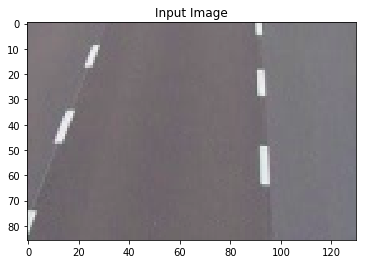

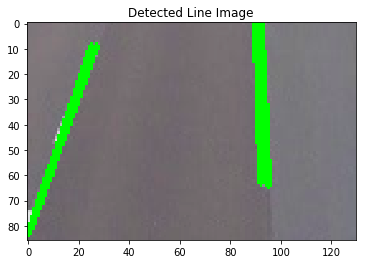

In [38]:
#Read image 
img = cv2.imread('line.png', cv2.IMREAD_COLOR)

# Visualize the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()

#### YOUR CODE STARTS HERE #####
#convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#### YOUR CODE ENDS HERE #####

#Find the edges in the image using canny detector

edges = cv2.Canny(gray,50,150,apertureSize = 3)
#### YOUR CODE STARTS HERE #####
lines = cv2.HoughLinesP(edges,rho=1,theta=np.pi/180,threshold=15,minLineLength=60, maxLineGap=250)
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2) 

#### YOUR CODE ENDS HERE #####
plt.imshow(img)
plt.title('Detected Line Image')
plt.show()

##Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

What is the estimated number of inliers for an outlier rate of 0.9?


In [39]:
import numpy as np
np.random.seed(0)


# Affine Transformation
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# points_t =    A   * points_s  + t

# -------------------------------------------------------------

class Transform():

    def create_case(self, out_rate):
        ''' CREATE_CASE

            Method to generate a test case for affine transformation

            Input arguments:
            - out_rate : the percentage of outliers in test case

            Outputs:
            - points_s : Source points that will be transformed
            - points_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''


        # Generate an affine transformation
        # A is a 2x2 matrix, with values in range -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # t is a 2x1 vector, with values in range -10 to 10
        t = 20 * np.random.rand(2, 1) - 10

        # Set the num_points = 1000 for the test case
        num_points = 1000

        #### YOUR CODE STARTS HERE ####
        # Compute the no. of outliers and the no. of inliers respectively
        outliers = int(out_rate*num_points)
        inliers = num_points - outliers
        #### YOUR CODE ENDS HERE ####

        # Gernerate source points, with scope from (0,0) to (100, 100)
        points_s = 100 * np.random.rand(2, num_points)

        # Initialization of the warped points matrix
        points_t = np.zeros((2, num_points))

        #### YOUR CODE STARTS HERE ####
        # Compute inliers in warped points matrix by applying A and t
        points_t[:, :inliers] = np.matmul(A, points_s[:,:inliers]) + t
        #### YOUR CODE ENDS HERE ####

        # Outliers in warped points matrix
        points_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix
        # outliers and inliers will scatter randomly in test case
        rand_inx = np.random.permutation(num_points)
        points_s = points_s[:, rand_inx]
        points_t = points_t[:, rand_inx]

        return A, t, points_s, points_t

    def affine_transformation(self, points_s, points_t):  
        ''' AFFINE_TRANSFORMATION

            Perform affine transformation

            Input arguments:
            - points_t : points in target image
            - points_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation by calculating:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''

        #### YOUR CODE STARTS HERE ####
        s_p = points_s[:, :,0]
        t_p = points_t[:, :,0]

        M = np.asarray([[s_p[0,0], s_p[1,0], 0, 0, 1, 0],
                        [0, 0, s_p[0,0], s_p[1,0], 0, 1],
                        [s_p[0,1], s_p[1,1], 0, 0, 1, 0],
                        [0, 0, s_p[0,1], s_p[1,1], 0, 1],
                        [s_p[0,2], s_p[1,2], 0, 0, 1, 0],
                        [0, 0, s_p[0,2], s_p[1,2], 0, 1]])
        b = np.asarray([t_p[0,0], t_p[1,0], t_p[0,1], t_p[1,1], t_p[0,2], t_p[1,2]])
        
        M_inv = np.linalg.pinv(M)
        theta = np.dot(M_inv, b)
        
        A = theta[:4].reshape(2,2)
        t = theta[4:].reshape(2,1)
        return A,t

        #### YOUR CODE ENDS HERE ####
# -------------------------------------------------------------

# Create instance
tf = Transform()

# Generate a test case as validation with
# a rate of outliers
out_rate = 0.90
A_true, t_true, points_s, points_t = tf.create_case(out_rate)
# print(A_true, t_true)
# At least 3 corresponding points to
# estimate affine transformation
L = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, points_s.shape[1], (L, 1))

A_test, t_test = tf.affine_transformation(points_s[:, idx], points_t[:, idx])
# print(A_test, t_test)
# -------------------------------------------------------------
# Test Class RansacClass
# The number of iterations in RANSAC
ITER_NUM = 2000


class RansacClass():

    def __init__(self, L=3, thr=1): 
        ''' __INIT__

            Initialize the instance.

            Input arguments:

            - L : the number of corresponding points,
            default is 3
            - thr : threshold that determines which points are inliers
            by comparing residual with it

        '''

        self.L = L
        self.thr = thr

    def calculate_distance(self, A, t, points_s, points_t):     
        ''' CALCULATE_DISTANCE

            Compute residual length between estimation and 
            real target points.
 

            Input arguments:

            - A, t : the estimated affine transformation
                     (using least square)
            - points_s : key points taken from source image
            - points_t : key points taken from target image

            Output:

            - residual : Euclidean distance between target 
            points and estimated points. Euclidean distance is
            nothing but the residual length

        '''

        ###YOUR CODE START HERE
        
        points_t_estimate = np.matmul(A, points_s) + t
        dist = np.sqrt(np.sum((points_t_estimate-points_t)**2,0))
        return dist

        ###YOUR CODE ENDS HERE

    def apply_ransac(self, points_s, points_t):
        ''' APPLY_RANSAC

            Use this method to get the estimateda ffine 
            transformation, also inliers.

            Input arguments:

            - points_s : key points from source image
            - points_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers 

        '''
        #### YOUR CODE START HERE
        
        num_inliers = 0
        A, t, max_inliers = None, None, None
        for it in range(ITER_NUM):
            idx = np.random.randint(0, points_s.shape[1], (3, 1))
            A_test, t_test = tf.affine_transformation(points_s[:, idx], points_t[:, idx])
            
            dist = self.calculate_distance(A_test, t_test, points_s, points_t)
            inliers = dist[dist<=self.thr]
            if inliers.shape[0] > num_inliers:
                A, t = A_test, t_test
                num_inliers = inliers.shape[0]
                max_inliers= inliers
                
        return A, t, max_inliers
        
        #### YOUR CODE ENDS HERE
# -------------------------------------------------------------

# Create instance
rs = RansacClass(L=3, thr=1)

residual = rs.calculate_distance(A_test, t_test, points_s, points_t)
A_rsc, t_rsc, inliers = rs.apply_ransac(points_s, points_t)

# print the number of inliners or point matches
print(inliers.shape[0])


101


### Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image (line.png) using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

How many corners are detected?



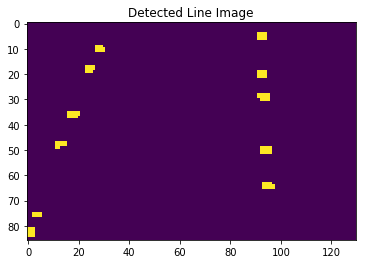

135 corner points detected corresponding to 11 corners spots


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('line.png')

# Make a copy of the image
image_copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

###YOUR CODE STARTS HERE

## STEP 1:  Convert to grayscale 
gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
# STEP 2: Detect corners 
responses = cv2.cornerHarris(gray_image,2,3,0.04)

## STEP 3: Dilate corner image to enhance corner points

responses = cv2.dilate(responses, kernel=np.ones((2,2), np.uint8) )

## STEP 4:set threshold value as 0.1 * (maximum value of dilated corner image obtained from STEP3)
thr = 0.1*responses.max()
responses = (responses>=thr).astype(np.float32)
plt.imshow(responses)
plt.title('Detected Line Image')
plt.show()
## STEP 5: Count numer of detected corner points and draw them on the image

print('{} corner points detected corresponding to 11 corners spots'.format(int(responses.sum())))
### YOUR CODE ENDS HERE

# Part-2

In this section, we will train a neural network to learn to identify numerals from [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Fill out the missing pieces in each of the following cells. 

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Data Loading and Pre-processing

In [9]:
# check availability of GPU and set the device accordingly
#### YOUR CODE STARTS HERE ####
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# define a transforms for preparing the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.1307,), std=(0.3081,))])
         # convert the image to a pytorch tensor
        # normalise the images with mean (0.1307) and std (0.3081) of the dataset
#### YOUR CODE ENDS HERE ####

In [4]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
train_dataset = datasets.MNIST('./', download=True, train=True, transform=transform)
test_dataset = datasets.MNIST('./', download=True, train=False, transform=transform)
#### YOUR CODE ENDS HERE ####

In [5]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
#### YOUR CODE ENDS HERE ####

### Network Definition

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1)

        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1)
        
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1)

        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout(0.25)
        
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout(0.25)
        
        # define a linear(dense) layer with 128 output features
        self.linear1 = nn.Linear(64*11*11, 128)
        
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.linear2 = nn.Linear(128, 10)
        
        
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out = F.relu(self.conv1(x))
#         print(out.shape)
        out = F.relu(self.conv2(out))
#         print(out.shape)
        out = F.relu(self.conv3(out))
        out = self.maxpool(out)
        out = self.dropout1(out)
#         print(out.shape)
        out = torch.flatten(out,1)
        out = F.relu(self.linear1(out))
        out = self.dropout2(out)
        out = self.linear2(out)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output


### Sanity Check
Make sure all the tests below pass without any errors, before you proceed with the training part.

In [7]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_dataloader.batch_size == 32)
        self.assertTrue(test_dataloader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 2.421s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### Training and Inference

In [10]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data, target = data.to(device), target.to(device)
        
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()

        # pass the image to the model and assign the output to variable named output
        output = net(data)
        
        # calculate the loss (use nll_loss in pytorch)
        loss = F.nll_loss(output, target)
        
        # do a backward pass
        loss.backward()
        
        # update the weights
        optimizer.step()
        
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [11]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data, target = data.to(device), target.to(device)
            
            # pass the image to the model and assign the output to variable named output
            output = net(data)
            loss = F.nll_loss(output, target)
            
            test_loss += loss.item() # sum up batch loss
          #### YOUR CODE ENDS HERE ####
            # get the index of the max log-probability
            pred = torch.argmax(output,1)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Question 4

Use Adam as the optimiser and train the model for 25 epochs. Report the train, test loss and accuracies along with the total time taken for training. (Use plots if required)

In [19]:
import time
net = Net()
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters())
t0 = time.time()
for epoch in range(25):
    train(net, device, train_dataloader, optimizer, epoch)
t1 = time.time()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309485
Train Epoch: 0 [640/60000 (1%)]	Loss: 1.161811
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.749271
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.403051
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.186490
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.388200
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.062952
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.430691
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.444886
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.648206
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.261667
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.076565
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.261695
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.124053
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.207244
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.077797
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.081707
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.159780
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.125796
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.081979
Train Epoch: 0 [12800/60000 (

Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.016558
Train Epoch: 1 [46720/60000 (78%)]	Loss: 0.005886
Train Epoch: 1 [47360/60000 (79%)]	Loss: 0.133017
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.053048
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.093159
Train Epoch: 1 [49280/60000 (82%)]	Loss: 0.008208
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.001184
Train Epoch: 1 [50560/60000 (84%)]	Loss: 0.002687
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.059790
Train Epoch: 1 [51840/60000 (86%)]	Loss: 0.099727
Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.004975
Train Epoch: 1 [53120/60000 (89%)]	Loss: 0.004207
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.007213
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.031336
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.009325
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.037716
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.238976
Train Epoch: 1 [56960/60000 (95%)]	Loss: 0.025912
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.055263
Train Epoch: 1 [58240/60000 (97%)]	Loss: 0.015449


Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.000368
Train Epoch: 3 [32640/60000 (54%)]	Loss: 0.003041
Train Epoch: 3 [33280/60000 (55%)]	Loss: 0.234363
Train Epoch: 3 [33920/60000 (57%)]	Loss: 0.040604
Train Epoch: 3 [34560/60000 (58%)]	Loss: 0.000678
Train Epoch: 3 [35200/60000 (59%)]	Loss: 0.012299
Train Epoch: 3 [35840/60000 (60%)]	Loss: 0.053272
Train Epoch: 3 [36480/60000 (61%)]	Loss: 0.082412
Train Epoch: 3 [37120/60000 (62%)]	Loss: 0.004800
Train Epoch: 3 [37760/60000 (63%)]	Loss: 0.002208
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.008132
Train Epoch: 3 [39040/60000 (65%)]	Loss: 0.001060
Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.001643
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.318562
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.003449
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.183840
Train Epoch: 3 [42240/60000 (70%)]	Loss: 0.010871
Train Epoch: 3 [42880/60000 (71%)]	Loss: 0.006874
Train Epoch: 3 [43520/60000 (73%)]	Loss: 0.003860
Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.007448


Train Epoch: 5 [17920/60000 (30%)]	Loss: 0.001149
Train Epoch: 5 [18560/60000 (31%)]	Loss: 0.028095
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.001515
Train Epoch: 5 [19840/60000 (33%)]	Loss: 0.007654
Train Epoch: 5 [20480/60000 (34%)]	Loss: 0.078571
Train Epoch: 5 [21120/60000 (35%)]	Loss: 0.024697
Train Epoch: 5 [21760/60000 (36%)]	Loss: 0.000435
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.148549
Train Epoch: 5 [23040/60000 (38%)]	Loss: 0.000111
Train Epoch: 5 [23680/60000 (39%)]	Loss: 0.000754
Train Epoch: 5 [24320/60000 (41%)]	Loss: 0.042303
Train Epoch: 5 [24960/60000 (42%)]	Loss: 0.000668
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.001694
Train Epoch: 5 [26240/60000 (44%)]	Loss: 0.041378
Train Epoch: 5 [26880/60000 (45%)]	Loss: 0.000953
Train Epoch: 5 [27520/60000 (46%)]	Loss: 0.000125
Train Epoch: 5 [28160/60000 (47%)]	Loss: 0.011702
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.001353
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.001250
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.134921


Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.000121
Train Epoch: 7 [4480/60000 (7%)]	Loss: 0.005420
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.000121
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.000335
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.001235
Train Epoch: 7 [7040/60000 (12%)]	Loss: 0.000310
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.001348
Train Epoch: 7 [8320/60000 (14%)]	Loss: 0.009496
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.000157
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.000043
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.000162
Train Epoch: 7 [10880/60000 (18%)]	Loss: 0.000012
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.002770
Train Epoch: 7 [12160/60000 (20%)]	Loss: 0.073831
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.001369
Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.000067
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.000115
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.000051
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.029844
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.152290
Train Epoch: 

Train Epoch: 8 [49920/60000 (83%)]	Loss: 0.000115
Train Epoch: 8 [50560/60000 (84%)]	Loss: 0.006908
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.004751
Train Epoch: 8 [51840/60000 (86%)]	Loss: 0.000333
Train Epoch: 8 [52480/60000 (87%)]	Loss: 0.053679
Train Epoch: 8 [53120/60000 (89%)]	Loss: 0.002134
Train Epoch: 8 [53760/60000 (90%)]	Loss: 0.016623
Train Epoch: 8 [54400/60000 (91%)]	Loss: 0.000725
Train Epoch: 8 [55040/60000 (92%)]	Loss: 0.001726
Train Epoch: 8 [55680/60000 (93%)]	Loss: 0.100721
Train Epoch: 8 [56320/60000 (94%)]	Loss: 0.012234
Train Epoch: 8 [56960/60000 (95%)]	Loss: 0.008809
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000225
Train Epoch: 8 [58240/60000 (97%)]	Loss: 0.001145
Train Epoch: 8 [58880/60000 (98%)]	Loss: 0.003107
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.000154
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.001736
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.003827
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.000198
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.000037
Train Epoch:

Train Epoch: 10 [34560/60000 (58%)]	Loss: 0.000042
Train Epoch: 10 [35200/60000 (59%)]	Loss: 0.000001
Train Epoch: 10 [35840/60000 (60%)]	Loss: 0.003320
Train Epoch: 10 [36480/60000 (61%)]	Loss: 0.038812
Train Epoch: 10 [37120/60000 (62%)]	Loss: 0.000186
Train Epoch: 10 [37760/60000 (63%)]	Loss: 0.007910
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.105623
Train Epoch: 10 [39040/60000 (65%)]	Loss: 0.001621
Train Epoch: 10 [39680/60000 (66%)]	Loss: 0.000406
Train Epoch: 10 [40320/60000 (67%)]	Loss: 0.115474
Train Epoch: 10 [40960/60000 (68%)]	Loss: 0.000060
Train Epoch: 10 [41600/60000 (69%)]	Loss: 0.002423
Train Epoch: 10 [42240/60000 (70%)]	Loss: 0.056942
Train Epoch: 10 [42880/60000 (71%)]	Loss: 0.027382
Train Epoch: 10 [43520/60000 (73%)]	Loss: 0.006585
Train Epoch: 10 [44160/60000 (74%)]	Loss: 0.096424
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.027714
Train Epoch: 10 [45440/60000 (76%)]	Loss: 0.001742
Train Epoch: 10 [46080/60000 (77%)]	Loss: 0.000859
Train Epoch: 10 [46720/60000 (7

Train Epoch: 12 [17920/60000 (30%)]	Loss: 0.000435
Train Epoch: 12 [18560/60000 (31%)]	Loss: 0.032795
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.000079
Train Epoch: 12 [19840/60000 (33%)]	Loss: 0.000130
Train Epoch: 12 [20480/60000 (34%)]	Loss: 0.000119
Train Epoch: 12 [21120/60000 (35%)]	Loss: 0.000159
Train Epoch: 12 [21760/60000 (36%)]	Loss: 0.038078
Train Epoch: 12 [22400/60000 (37%)]	Loss: 0.005093
Train Epoch: 12 [23040/60000 (38%)]	Loss: 0.008922
Train Epoch: 12 [23680/60000 (39%)]	Loss: 0.000012
Train Epoch: 12 [24320/60000 (41%)]	Loss: 0.000006
Train Epoch: 12 [24960/60000 (42%)]	Loss: 0.008684
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.088149
Train Epoch: 12 [26240/60000 (44%)]	Loss: 0.037661
Train Epoch: 12 [26880/60000 (45%)]	Loss: 0.111541
Train Epoch: 12 [27520/60000 (46%)]	Loss: 0.004121
Train Epoch: 12 [28160/60000 (47%)]	Loss: 0.004226
Train Epoch: 12 [28800/60000 (48%)]	Loss: 0.000161
Train Epoch: 12 [29440/60000 (49%)]	Loss: 0.005183
Train Epoch: 12 [30080/60000 (5

Train Epoch: 14 [1280/60000 (2%)]	Loss: 0.000317
Train Epoch: 14 [1920/60000 (3%)]	Loss: 0.003674
Train Epoch: 14 [2560/60000 (4%)]	Loss: 0.000082
Train Epoch: 14 [3200/60000 (5%)]	Loss: 0.005915
Train Epoch: 14 [3840/60000 (6%)]	Loss: 0.000008
Train Epoch: 14 [4480/60000 (7%)]	Loss: 0.000157
Train Epoch: 14 [5120/60000 (9%)]	Loss: 0.000366
Train Epoch: 14 [5760/60000 (10%)]	Loss: 0.000053
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.000329
Train Epoch: 14 [7040/60000 (12%)]	Loss: 0.001962
Train Epoch: 14 [7680/60000 (13%)]	Loss: 0.000039
Train Epoch: 14 [8320/60000 (14%)]	Loss: 0.000007
Train Epoch: 14 [8960/60000 (15%)]	Loss: 0.000606
Train Epoch: 14 [9600/60000 (16%)]	Loss: 0.000023
Train Epoch: 14 [10240/60000 (17%)]	Loss: 0.004547
Train Epoch: 14 [10880/60000 (18%)]	Loss: 0.039198
Train Epoch: 14 [11520/60000 (19%)]	Loss: 0.037446
Train Epoch: 14 [12160/60000 (20%)]	Loss: 0.000172
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.003993
Train Epoch: 14 [13440/60000 (22%)]	Loss: 0.065942
T

Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.000017
Train Epoch: 15 [45440/60000 (76%)]	Loss: 0.000001
Train Epoch: 15 [46080/60000 (77%)]	Loss: 0.000000
Train Epoch: 15 [46720/60000 (78%)]	Loss: 0.000040
Train Epoch: 15 [47360/60000 (79%)]	Loss: 0.000008
Train Epoch: 15 [48000/60000 (80%)]	Loss: 0.067791
Train Epoch: 15 [48640/60000 (81%)]	Loss: 0.245921
Train Epoch: 15 [49280/60000 (82%)]	Loss: 0.027303
Train Epoch: 15 [49920/60000 (83%)]	Loss: 0.000005
Train Epoch: 15 [50560/60000 (84%)]	Loss: 0.005217
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.009445
Train Epoch: 15 [51840/60000 (86%)]	Loss: 0.003562
Train Epoch: 15 [52480/60000 (87%)]	Loss: 0.000325
Train Epoch: 15 [53120/60000 (89%)]	Loss: 0.000009
Train Epoch: 15 [53760/60000 (90%)]	Loss: 0.000001
Train Epoch: 15 [54400/60000 (91%)]	Loss: 0.001715
Train Epoch: 15 [55040/60000 (92%)]	Loss: 0.021813
Train Epoch: 15 [55680/60000 (93%)]	Loss: 0.314824
Train Epoch: 15 [56320/60000 (94%)]	Loss: 0.000005
Train Epoch: 15 [56960/60000 (9

Train Epoch: 17 [28160/60000 (47%)]	Loss: 0.001138
Train Epoch: 17 [28800/60000 (48%)]	Loss: 0.000010
Train Epoch: 17 [29440/60000 (49%)]	Loss: 0.004016
Train Epoch: 17 [30080/60000 (50%)]	Loss: 0.004439
Train Epoch: 17 [30720/60000 (51%)]	Loss: 0.009176
Train Epoch: 17 [31360/60000 (52%)]	Loss: 0.000846
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.000008
Train Epoch: 17 [32640/60000 (54%)]	Loss: 0.006812
Train Epoch: 17 [33280/60000 (55%)]	Loss: 0.000016
Train Epoch: 17 [33920/60000 (57%)]	Loss: 0.059770
Train Epoch: 17 [34560/60000 (58%)]	Loss: 0.009360
Train Epoch: 17 [35200/60000 (59%)]	Loss: 0.000055
Train Epoch: 17 [35840/60000 (60%)]	Loss: 0.000417
Train Epoch: 17 [36480/60000 (61%)]	Loss: 0.062957
Train Epoch: 17 [37120/60000 (62%)]	Loss: 0.021755
Train Epoch: 17 [37760/60000 (63%)]	Loss: 0.015940
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.022226
Train Epoch: 17 [39040/60000 (65%)]	Loss: 0.000006
Train Epoch: 17 [39680/60000 (66%)]	Loss: 0.000016
Train Epoch: 17 [40320/60000 (6

Train Epoch: 19 [11520/60000 (19%)]	Loss: 0.000011
Train Epoch: 19 [12160/60000 (20%)]	Loss: 0.144995
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.000001
Train Epoch: 19 [13440/60000 (22%)]	Loss: 0.003476
Train Epoch: 19 [14080/60000 (23%)]	Loss: 0.000004
Train Epoch: 19 [14720/60000 (25%)]	Loss: 0.000007
Train Epoch: 19 [15360/60000 (26%)]	Loss: 0.000001
Train Epoch: 19 [16000/60000 (27%)]	Loss: 0.026645
Train Epoch: 19 [16640/60000 (28%)]	Loss: 0.000019
Train Epoch: 19 [17280/60000 (29%)]	Loss: 0.000239
Train Epoch: 19 [17920/60000 (30%)]	Loss: 0.005669
Train Epoch: 19 [18560/60000 (31%)]	Loss: 0.010410
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.000001
Train Epoch: 19 [19840/60000 (33%)]	Loss: 0.000031
Train Epoch: 19 [20480/60000 (34%)]	Loss: 0.000024
Train Epoch: 19 [21120/60000 (35%)]	Loss: 0.004113
Train Epoch: 19 [21760/60000 (36%)]	Loss: 0.000011
Train Epoch: 19 [22400/60000 (37%)]	Loss: 0.000007
Train Epoch: 19 [23040/60000 (38%)]	Loss: 0.000241
Train Epoch: 19 [23680/60000 (3

Train Epoch: 20 [55040/60000 (92%)]	Loss: 0.000900
Train Epoch: 20 [55680/60000 (93%)]	Loss: 0.000000
Train Epoch: 20 [56320/60000 (94%)]	Loss: 0.000003
Train Epoch: 20 [56960/60000 (95%)]	Loss: 0.010811
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.000814
Train Epoch: 20 [58240/60000 (97%)]	Loss: 0.000005
Train Epoch: 20 [58880/60000 (98%)]	Loss: 0.065015
Train Epoch: 20 [59520/60000 (99%)]	Loss: 0.000670
Train Epoch: 21 [0/60000 (0%)]	Loss: 0.000114
Train Epoch: 21 [640/60000 (1%)]	Loss: 0.060927
Train Epoch: 21 [1280/60000 (2%)]	Loss: 0.000107
Train Epoch: 21 [1920/60000 (3%)]	Loss: 0.002608
Train Epoch: 21 [2560/60000 (4%)]	Loss: 0.001434
Train Epoch: 21 [3200/60000 (5%)]	Loss: 0.000002
Train Epoch: 21 [3840/60000 (6%)]	Loss: 0.000089
Train Epoch: 21 [4480/60000 (7%)]	Loss: 0.058620
Train Epoch: 21 [5120/60000 (9%)]	Loss: 0.074418
Train Epoch: 21 [5760/60000 (10%)]	Loss: 0.000001
Train Epoch: 21 [6400/60000 (11%)]	Loss: 0.000019
Train Epoch: 21 [7040/60000 (12%)]	Loss: 0.001268
Train

Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.000000
Train Epoch: 22 [39040/60000 (65%)]	Loss: 0.000352
Train Epoch: 22 [39680/60000 (66%)]	Loss: 0.000001
Train Epoch: 22 [40320/60000 (67%)]	Loss: 0.016899
Train Epoch: 22 [40960/60000 (68%)]	Loss: 0.000000
Train Epoch: 22 [41600/60000 (69%)]	Loss: 0.000002
Train Epoch: 22 [42240/60000 (70%)]	Loss: 0.044771
Train Epoch: 22 [42880/60000 (71%)]	Loss: 0.000027
Train Epoch: 22 [43520/60000 (73%)]	Loss: 0.052424
Train Epoch: 22 [44160/60000 (74%)]	Loss: 0.004640
Train Epoch: 22 [44800/60000 (75%)]	Loss: 0.000001
Train Epoch: 22 [45440/60000 (76%)]	Loss: 0.072163
Train Epoch: 22 [46080/60000 (77%)]	Loss: 0.000002
Train Epoch: 22 [46720/60000 (78%)]	Loss: 0.000000
Train Epoch: 22 [47360/60000 (79%)]	Loss: 0.000006
Train Epoch: 22 [48000/60000 (80%)]	Loss: 0.000000
Train Epoch: 22 [48640/60000 (81%)]	Loss: 0.000000
Train Epoch: 22 [49280/60000 (82%)]	Loss: 0.000022
Train Epoch: 22 [49920/60000 (83%)]	Loss: 0.000000
Train Epoch: 22 [50560/60000 (8

Train Epoch: 24 [21760/60000 (36%)]	Loss: 0.001075
Train Epoch: 24 [22400/60000 (37%)]	Loss: 0.000168
Train Epoch: 24 [23040/60000 (38%)]	Loss: 0.000059
Train Epoch: 24 [23680/60000 (39%)]	Loss: 0.000004
Train Epoch: 24 [24320/60000 (41%)]	Loss: 0.000002
Train Epoch: 24 [24960/60000 (42%)]	Loss: 0.000009
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.000001
Train Epoch: 24 [26240/60000 (44%)]	Loss: 0.000038
Train Epoch: 24 [26880/60000 (45%)]	Loss: 0.000014
Train Epoch: 24 [27520/60000 (46%)]	Loss: 0.000005
Train Epoch: 24 [28160/60000 (47%)]	Loss: 0.000002
Train Epoch: 24 [28800/60000 (48%)]	Loss: 0.000196
Train Epoch: 24 [29440/60000 (49%)]	Loss: 0.000811
Train Epoch: 24 [30080/60000 (50%)]	Loss: 0.000001
Train Epoch: 24 [30720/60000 (51%)]	Loss: 0.000861
Train Epoch: 24 [31360/60000 (52%)]	Loss: 0.000102
Train Epoch: 24 [32000/60000 (53%)]	Loss: 0.000001
Train Epoch: 24 [32640/60000 (54%)]	Loss: 0.000047
Train Epoch: 24 [33280/60000 (55%)]	Loss: 0.289679
Train Epoch: 24 [33920/60000 (5

In [20]:
print('Total training time (s) : ', t1-t0)
print('Results on Training data')
test(net, device, train_dataloader)
print('Results on Test data')
test(net, device, test_dataloader)

Total training time (s) :  405.19320130348206
Results on Training data

Test set: Average loss: 0.0000, Accuracy: 59973/60000 (99.95%)

Results on Test data

Test set: Average loss: 0.0012, Accuracy: 9935/10000 (99.35%)



### Question 5

Modify the network defined in the previous step to replace ReLU activations with Sigmoid and report the final test accuracy. Is there a drop in accuracy, what do you think is the reason? 

In [17]:
import time
class Net2(Net):
    def __init__(self):
        super(Net2, self).__init__()
        
    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out = F.sigmoid(self.conv1(x))
        out = F.sigmoid(self.conv2(out))
        out = F.sigmoid(self.conv3(out))
        out = self.maxpool(out)
        out = self.dropout1(out)
        out = torch.flatten(out,1)
        out = F.sigmoid(self.linear1(out))
        out = self.dropout2(out)
        out = self.linear2(out)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

net = Net2()
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
t0 = time.time()
for epoch in range(25):
    train(net, device, train_dataloader, optimizer, epoch)
t1 = time.time()


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.364189
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.243435
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.284987
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.323602
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.345514
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.300038
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.314976
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.259122
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.409592
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.322113
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.319152
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.344760
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.318432
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.317401
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.331629
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.301688
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.368168
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.311502
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.295294
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.261208
Train Epoch: 0 [12800/60000 (

Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.078506
Train Epoch: 1 [46720/60000 (78%)]	Loss: 0.019915
Train Epoch: 1 [47360/60000 (79%)]	Loss: 0.054471
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.017162
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.073577
Train Epoch: 1 [49280/60000 (82%)]	Loss: 0.129769
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.011832
Train Epoch: 1 [50560/60000 (84%)]	Loss: 0.013219
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.094362
Train Epoch: 1 [51840/60000 (86%)]	Loss: 0.026051
Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.020936
Train Epoch: 1 [53120/60000 (89%)]	Loss: 0.048071
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.038102
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.042134
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.005121
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.064823
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.013426
Train Epoch: 1 [56960/60000 (95%)]	Loss: 0.151615
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.030597
Train Epoch: 1 [58240/60000 (97%)]	Loss: 0.010598


Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.016919
Train Epoch: 3 [32640/60000 (54%)]	Loss: 0.073162
Train Epoch: 3 [33280/60000 (55%)]	Loss: 0.063141
Train Epoch: 3 [33920/60000 (57%)]	Loss: 0.033233
Train Epoch: 3 [34560/60000 (58%)]	Loss: 0.009638
Train Epoch: 3 [35200/60000 (59%)]	Loss: 0.026883
Train Epoch: 3 [35840/60000 (60%)]	Loss: 0.005849
Train Epoch: 3 [36480/60000 (61%)]	Loss: 0.069087
Train Epoch: 3 [37120/60000 (62%)]	Loss: 0.015288
Train Epoch: 3 [37760/60000 (63%)]	Loss: 0.247714
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.110250
Train Epoch: 3 [39040/60000 (65%)]	Loss: 0.078012
Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.016691
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.020403
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.076542
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.005165
Train Epoch: 3 [42240/60000 (70%)]	Loss: 0.004725
Train Epoch: 3 [42880/60000 (71%)]	Loss: 0.043735
Train Epoch: 3 [43520/60000 (73%)]	Loss: 0.001572
Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.005144


Train Epoch: 5 [17920/60000 (30%)]	Loss: 0.002075
Train Epoch: 5 [18560/60000 (31%)]	Loss: 0.000894
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.088858
Train Epoch: 5 [19840/60000 (33%)]	Loss: 0.001027
Train Epoch: 5 [20480/60000 (34%)]	Loss: 0.008572
Train Epoch: 5 [21120/60000 (35%)]	Loss: 0.514790
Train Epoch: 5 [21760/60000 (36%)]	Loss: 0.002350
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.046638
Train Epoch: 5 [23040/60000 (38%)]	Loss: 0.002382
Train Epoch: 5 [23680/60000 (39%)]	Loss: 0.066723
Train Epoch: 5 [24320/60000 (41%)]	Loss: 0.037606
Train Epoch: 5 [24960/60000 (42%)]	Loss: 0.016696
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.011959
Train Epoch: 5 [26240/60000 (44%)]	Loss: 0.022683
Train Epoch: 5 [26880/60000 (45%)]	Loss: 0.003086
Train Epoch: 5 [27520/60000 (46%)]	Loss: 0.009144
Train Epoch: 5 [28160/60000 (47%)]	Loss: 0.010808
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.005583
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.004003
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.003693


Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.059602
Train Epoch: 7 [4480/60000 (7%)]	Loss: 0.001682
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.007425
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.013972
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.032211
Train Epoch: 7 [7040/60000 (12%)]	Loss: 0.004530
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.173409
Train Epoch: 7 [8320/60000 (14%)]	Loss: 0.002053
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.052536
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.018788
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.006724
Train Epoch: 7 [10880/60000 (18%)]	Loss: 0.008338
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.016820
Train Epoch: 7 [12160/60000 (20%)]	Loss: 0.004516
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.013491
Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.062126
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.055589
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.002692
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.003456
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.085316
Train Epoch: 

Train Epoch: 8 [49920/60000 (83%)]	Loss: 0.000780
Train Epoch: 8 [50560/60000 (84%)]	Loss: 0.001557
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000609
Train Epoch: 8 [51840/60000 (86%)]	Loss: 0.001096
Train Epoch: 8 [52480/60000 (87%)]	Loss: 0.056816
Train Epoch: 8 [53120/60000 (89%)]	Loss: 0.001132
Train Epoch: 8 [53760/60000 (90%)]	Loss: 0.004349
Train Epoch: 8 [54400/60000 (91%)]	Loss: 0.000322
Train Epoch: 8 [55040/60000 (92%)]	Loss: 0.006675
Train Epoch: 8 [55680/60000 (93%)]	Loss: 0.003714
Train Epoch: 8 [56320/60000 (94%)]	Loss: 0.046679
Train Epoch: 8 [56960/60000 (95%)]	Loss: 0.015656
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.001234
Train Epoch: 8 [58240/60000 (97%)]	Loss: 0.038260
Train Epoch: 8 [58880/60000 (98%)]	Loss: 0.000343
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.022919
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.001097
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.001484
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.028750
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.001046
Train Epoch:

Train Epoch: 10 [34560/60000 (58%)]	Loss: 0.000255
Train Epoch: 10 [35200/60000 (59%)]	Loss: 0.000347
Train Epoch: 10 [35840/60000 (60%)]	Loss: 0.016482
Train Epoch: 10 [36480/60000 (61%)]	Loss: 0.001243
Train Epoch: 10 [37120/60000 (62%)]	Loss: 0.001238
Train Epoch: 10 [37760/60000 (63%)]	Loss: 0.006618
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.034197
Train Epoch: 10 [39040/60000 (65%)]	Loss: 0.000151
Train Epoch: 10 [39680/60000 (66%)]	Loss: 0.108343
Train Epoch: 10 [40320/60000 (67%)]	Loss: 0.000364
Train Epoch: 10 [40960/60000 (68%)]	Loss: 0.001376
Train Epoch: 10 [41600/60000 (69%)]	Loss: 0.032253
Train Epoch: 10 [42240/60000 (70%)]	Loss: 0.009495
Train Epoch: 10 [42880/60000 (71%)]	Loss: 0.000455
Train Epoch: 10 [43520/60000 (73%)]	Loss: 0.000996
Train Epoch: 10 [44160/60000 (74%)]	Loss: 0.005621
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.003250
Train Epoch: 10 [45440/60000 (76%)]	Loss: 0.001460
Train Epoch: 10 [46080/60000 (77%)]	Loss: 0.040740
Train Epoch: 10 [46720/60000 (7

Train Epoch: 12 [17920/60000 (30%)]	Loss: 0.000338
Train Epoch: 12 [18560/60000 (31%)]	Loss: 0.000324
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.008444
Train Epoch: 12 [19840/60000 (33%)]	Loss: 0.000689
Train Epoch: 12 [20480/60000 (34%)]	Loss: 0.000906
Train Epoch: 12 [21120/60000 (35%)]	Loss: 0.021072
Train Epoch: 12 [21760/60000 (36%)]	Loss: 0.001046
Train Epoch: 12 [22400/60000 (37%)]	Loss: 0.013240
Train Epoch: 12 [23040/60000 (38%)]	Loss: 0.000486
Train Epoch: 12 [23680/60000 (39%)]	Loss: 0.074486
Train Epoch: 12 [24320/60000 (41%)]	Loss: 0.001141
Train Epoch: 12 [24960/60000 (42%)]	Loss: 0.009130
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.019463
Train Epoch: 12 [26240/60000 (44%)]	Loss: 0.042381
Train Epoch: 12 [26880/60000 (45%)]	Loss: 0.004326
Train Epoch: 12 [27520/60000 (46%)]	Loss: 0.007278
Train Epoch: 12 [28160/60000 (47%)]	Loss: 0.000925
Train Epoch: 12 [28800/60000 (48%)]	Loss: 0.000552
Train Epoch: 12 [29440/60000 (49%)]	Loss: 0.059804
Train Epoch: 12 [30080/60000 (5

Train Epoch: 14 [1280/60000 (2%)]	Loss: 0.001107
Train Epoch: 14 [1920/60000 (3%)]	Loss: 0.004766
Train Epoch: 14 [2560/60000 (4%)]	Loss: 0.000931
Train Epoch: 14 [3200/60000 (5%)]	Loss: 0.000855
Train Epoch: 14 [3840/60000 (6%)]	Loss: 0.004276
Train Epoch: 14 [4480/60000 (7%)]	Loss: 0.004105
Train Epoch: 14 [5120/60000 (9%)]	Loss: 0.000154
Train Epoch: 14 [5760/60000 (10%)]	Loss: 0.000922
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.000586
Train Epoch: 14 [7040/60000 (12%)]	Loss: 0.000166
Train Epoch: 14 [7680/60000 (13%)]	Loss: 0.001478
Train Epoch: 14 [8320/60000 (14%)]	Loss: 0.000234
Train Epoch: 14 [8960/60000 (15%)]	Loss: 0.019308
Train Epoch: 14 [9600/60000 (16%)]	Loss: 0.005031
Train Epoch: 14 [10240/60000 (17%)]	Loss: 0.000180
Train Epoch: 14 [10880/60000 (18%)]	Loss: 0.026426
Train Epoch: 14 [11520/60000 (19%)]	Loss: 0.000400
Train Epoch: 14 [12160/60000 (20%)]	Loss: 0.001494
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.003257
Train Epoch: 14 [13440/60000 (22%)]	Loss: 0.009360
T

Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.000375
Train Epoch: 15 [45440/60000 (76%)]	Loss: 0.000033
Train Epoch: 15 [46080/60000 (77%)]	Loss: 0.000086
Train Epoch: 15 [46720/60000 (78%)]	Loss: 0.000364
Train Epoch: 15 [47360/60000 (79%)]	Loss: 0.001870
Train Epoch: 15 [48000/60000 (80%)]	Loss: 0.037817
Train Epoch: 15 [48640/60000 (81%)]	Loss: 0.011333
Train Epoch: 15 [49280/60000 (82%)]	Loss: 0.001555
Train Epoch: 15 [49920/60000 (83%)]	Loss: 0.000183
Train Epoch: 15 [50560/60000 (84%)]	Loss: 0.000325
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.005518
Train Epoch: 15 [51840/60000 (86%)]	Loss: 0.066867
Train Epoch: 15 [52480/60000 (87%)]	Loss: 0.023022
Train Epoch: 15 [53120/60000 (89%)]	Loss: 0.000760
Train Epoch: 15 [53760/60000 (90%)]	Loss: 0.001047
Train Epoch: 15 [54400/60000 (91%)]	Loss: 0.000125
Train Epoch: 15 [55040/60000 (92%)]	Loss: 0.002674
Train Epoch: 15 [55680/60000 (93%)]	Loss: 0.014920
Train Epoch: 15 [56320/60000 (94%)]	Loss: 0.001991
Train Epoch: 15 [56960/60000 (9

Train Epoch: 17 [28160/60000 (47%)]	Loss: 0.000131
Train Epoch: 17 [28800/60000 (48%)]	Loss: 0.000702
Train Epoch: 17 [29440/60000 (49%)]	Loss: 0.000047
Train Epoch: 17 [30080/60000 (50%)]	Loss: 0.000029
Train Epoch: 17 [30720/60000 (51%)]	Loss: 0.000469
Train Epoch: 17 [31360/60000 (52%)]	Loss: 0.000809
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.000126
Train Epoch: 17 [32640/60000 (54%)]	Loss: 0.002075
Train Epoch: 17 [33280/60000 (55%)]	Loss: 0.021810
Train Epoch: 17 [33920/60000 (57%)]	Loss: 0.000216
Train Epoch: 17 [34560/60000 (58%)]	Loss: 0.001003
Train Epoch: 17 [35200/60000 (59%)]	Loss: 0.018787
Train Epoch: 17 [35840/60000 (60%)]	Loss: 0.001895
Train Epoch: 17 [36480/60000 (61%)]	Loss: 0.000062
Train Epoch: 17 [37120/60000 (62%)]	Loss: 0.000568
Train Epoch: 17 [37760/60000 (63%)]	Loss: 0.000090
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.000891
Train Epoch: 17 [39040/60000 (65%)]	Loss: 0.000583
Train Epoch: 17 [39680/60000 (66%)]	Loss: 0.001185
Train Epoch: 17 [40320/60000 (6

Train Epoch: 19 [11520/60000 (19%)]	Loss: 0.033265
Train Epoch: 19 [12160/60000 (20%)]	Loss: 0.000115
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.000173
Train Epoch: 19 [13440/60000 (22%)]	Loss: 0.002048
Train Epoch: 19 [14080/60000 (23%)]	Loss: 0.001075
Train Epoch: 19 [14720/60000 (25%)]	Loss: 0.011554
Train Epoch: 19 [15360/60000 (26%)]	Loss: 0.002314
Train Epoch: 19 [16000/60000 (27%)]	Loss: 0.000050
Train Epoch: 19 [16640/60000 (28%)]	Loss: 0.000426
Train Epoch: 19 [17280/60000 (29%)]	Loss: 0.002152
Train Epoch: 19 [17920/60000 (30%)]	Loss: 0.000080
Train Epoch: 19 [18560/60000 (31%)]	Loss: 0.001221
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.002840
Train Epoch: 19 [19840/60000 (33%)]	Loss: 0.000030
Train Epoch: 19 [20480/60000 (34%)]	Loss: 0.000620
Train Epoch: 19 [21120/60000 (35%)]	Loss: 0.000470
Train Epoch: 19 [21760/60000 (36%)]	Loss: 0.050093
Train Epoch: 19 [22400/60000 (37%)]	Loss: 0.002981
Train Epoch: 19 [23040/60000 (38%)]	Loss: 0.003812
Train Epoch: 19 [23680/60000 (3

Train Epoch: 20 [55040/60000 (92%)]	Loss: 0.000608
Train Epoch: 20 [55680/60000 (93%)]	Loss: 0.000959
Train Epoch: 20 [56320/60000 (94%)]	Loss: 0.000253
Train Epoch: 20 [56960/60000 (95%)]	Loss: 0.000063
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.000567
Train Epoch: 20 [58240/60000 (97%)]	Loss: 0.000338
Train Epoch: 20 [58880/60000 (98%)]	Loss: 0.000445
Train Epoch: 20 [59520/60000 (99%)]	Loss: 0.000253
Train Epoch: 21 [0/60000 (0%)]	Loss: 0.010439
Train Epoch: 21 [640/60000 (1%)]	Loss: 0.000263
Train Epoch: 21 [1280/60000 (2%)]	Loss: 0.000030
Train Epoch: 21 [1920/60000 (3%)]	Loss: 0.000389
Train Epoch: 21 [2560/60000 (4%)]	Loss: 0.004370
Train Epoch: 21 [3200/60000 (5%)]	Loss: 0.001220
Train Epoch: 21 [3840/60000 (6%)]	Loss: 0.019499
Train Epoch: 21 [4480/60000 (7%)]	Loss: 0.000828
Train Epoch: 21 [5120/60000 (9%)]	Loss: 0.000241
Train Epoch: 21 [5760/60000 (10%)]	Loss: 0.000907
Train Epoch: 21 [6400/60000 (11%)]	Loss: 0.010216
Train Epoch: 21 [7040/60000 (12%)]	Loss: 0.000213
Train

Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.000487
Train Epoch: 22 [39040/60000 (65%)]	Loss: 0.000079
Train Epoch: 22 [39680/60000 (66%)]	Loss: 0.001031
Train Epoch: 22 [40320/60000 (67%)]	Loss: 0.002103
Train Epoch: 22 [40960/60000 (68%)]	Loss: 0.000630
Train Epoch: 22 [41600/60000 (69%)]	Loss: 0.000931
Train Epoch: 22 [42240/60000 (70%)]	Loss: 0.000129
Train Epoch: 22 [42880/60000 (71%)]	Loss: 0.000022
Train Epoch: 22 [43520/60000 (73%)]	Loss: 0.032190
Train Epoch: 22 [44160/60000 (74%)]	Loss: 0.000580
Train Epoch: 22 [44800/60000 (75%)]	Loss: 0.000071
Train Epoch: 22 [45440/60000 (76%)]	Loss: 0.000012
Train Epoch: 22 [46080/60000 (77%)]	Loss: 0.004093
Train Epoch: 22 [46720/60000 (78%)]	Loss: 0.000374
Train Epoch: 22 [47360/60000 (79%)]	Loss: 0.010024
Train Epoch: 22 [48000/60000 (80%)]	Loss: 0.000235
Train Epoch: 22 [48640/60000 (81%)]	Loss: 0.001078
Train Epoch: 22 [49280/60000 (82%)]	Loss: 0.000023
Train Epoch: 22 [49920/60000 (83%)]	Loss: 0.000157
Train Epoch: 22 [50560/60000 (8

Train Epoch: 24 [21760/60000 (36%)]	Loss: 0.000133
Train Epoch: 24 [22400/60000 (37%)]	Loss: 0.001023
Train Epoch: 24 [23040/60000 (38%)]	Loss: 0.000046
Train Epoch: 24 [23680/60000 (39%)]	Loss: 0.000004
Train Epoch: 24 [24320/60000 (41%)]	Loss: 0.000024
Train Epoch: 24 [24960/60000 (42%)]	Loss: 0.000093
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.000048
Train Epoch: 24 [26240/60000 (44%)]	Loss: 0.000272
Train Epoch: 24 [26880/60000 (45%)]	Loss: 0.000017
Train Epoch: 24 [27520/60000 (46%)]	Loss: 0.002645
Train Epoch: 24 [28160/60000 (47%)]	Loss: 0.000188
Train Epoch: 24 [28800/60000 (48%)]	Loss: 0.000053
Train Epoch: 24 [29440/60000 (49%)]	Loss: 0.000225
Train Epoch: 24 [30080/60000 (50%)]	Loss: 0.000169
Train Epoch: 24 [30720/60000 (51%)]	Loss: 0.000032
Train Epoch: 24 [31360/60000 (52%)]	Loss: 0.001013
Train Epoch: 24 [32000/60000 (53%)]	Loss: 0.000009
Train Epoch: 24 [32640/60000 (54%)]	Loss: 0.000420
Train Epoch: 24 [33280/60000 (55%)]	Loss: 0.000317
Train Epoch: 24 [33920/60000 (5

In [18]:
print('Total training time (s) : ', t1-t0)
print('Results on Training data')
test(net, device, train_dataloader)
print('Results on Test data')
test(net, device, test_dataloader)
print('Accuracy decreases when Sigmoid is used instead of ReLU. Sigmoid is prone to saturation because of which network gradients starts vanishing and it fails to learn anything new')

Total training time (s) :  406.8553764820099
Results on Training data

Test set: Average loss: 0.0000, Accuracy: 59993/60000 (99.99%)

Results on Test data

Test set: Average loss: 0.0011, Accuracy: 9923/10000 (99.23%)

Accuracy decreases when Sigmoid is used instead of ReLU. Sigmoid is prone to saturation because of which network gradients starts vanishing and it fails to learn anything new


### Question 6

Train the network defined in Question-1 with a different optimiser other than Adam, do you see any difference in performance? Substantiate your observations with relevant explanations.

In [21]:
import time
net = Net()
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
t0 = time.time()
for epoch in range(25):
    train(net, device, train_dataloader, optimizer, epoch)
t1 = time.time()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.293999
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.301966
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.307960
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.299244
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.287533
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.306030
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.302756
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.299387
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.282420
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.291892
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.301478
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.293128
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.285429
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.288599
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.309880
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.292211
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.298800
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.287524
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.280210
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.292655
Train Epoch: 0 [12800/60000 (

Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.308808
Train Epoch: 1 [46720/60000 (78%)]	Loss: 0.553453
Train Epoch: 1 [47360/60000 (79%)]	Loss: 0.583016
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.299466
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.333623
Train Epoch: 1 [49280/60000 (82%)]	Loss: 0.485862
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.318481
Train Epoch: 1 [50560/60000 (84%)]	Loss: 0.272455
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.437818
Train Epoch: 1 [51840/60000 (86%)]	Loss: 0.374288
Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.384286
Train Epoch: 1 [53120/60000 (89%)]	Loss: 0.298686
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.494100
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.280120
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.520876
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.305798
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.553397
Train Epoch: 1 [56960/60000 (95%)]	Loss: 0.457873
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.375952
Train Epoch: 1 [58240/60000 (97%)]	Loss: 0.406032


Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.446997
Train Epoch: 3 [32640/60000 (54%)]	Loss: 0.170531
Train Epoch: 3 [33280/60000 (55%)]	Loss: 0.229437
Train Epoch: 3 [33920/60000 (57%)]	Loss: 0.262488
Train Epoch: 3 [34560/60000 (58%)]	Loss: 0.151153
Train Epoch: 3 [35200/60000 (59%)]	Loss: 0.231810
Train Epoch: 3 [35840/60000 (60%)]	Loss: 0.486069
Train Epoch: 3 [36480/60000 (61%)]	Loss: 0.498388
Train Epoch: 3 [37120/60000 (62%)]	Loss: 0.293944
Train Epoch: 3 [37760/60000 (63%)]	Loss: 0.051425
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.318322
Train Epoch: 3 [39040/60000 (65%)]	Loss: 0.201840
Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.274860
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.247438
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.388230
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.148300
Train Epoch: 3 [42240/60000 (70%)]	Loss: 0.254398
Train Epoch: 3 [42880/60000 (71%)]	Loss: 0.184827
Train Epoch: 3 [43520/60000 (73%)]	Loss: 0.290514
Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.444251


Train Epoch: 5 [17920/60000 (30%)]	Loss: 0.070575
Train Epoch: 5 [18560/60000 (31%)]	Loss: 0.214339
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.229192
Train Epoch: 5 [19840/60000 (33%)]	Loss: 0.180302
Train Epoch: 5 [20480/60000 (34%)]	Loss: 0.186210
Train Epoch: 5 [21120/60000 (35%)]	Loss: 0.151257
Train Epoch: 5 [21760/60000 (36%)]	Loss: 0.295424
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.234286
Train Epoch: 5 [23040/60000 (38%)]	Loss: 0.415792
Train Epoch: 5 [23680/60000 (39%)]	Loss: 0.228227
Train Epoch: 5 [24320/60000 (41%)]	Loss: 0.196608
Train Epoch: 5 [24960/60000 (42%)]	Loss: 0.065822
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.093246
Train Epoch: 5 [26240/60000 (44%)]	Loss: 0.114486
Train Epoch: 5 [26880/60000 (45%)]	Loss: 0.428920
Train Epoch: 5 [27520/60000 (46%)]	Loss: 0.202106
Train Epoch: 5 [28160/60000 (47%)]	Loss: 0.123623
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.127121
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.194717
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.456473


Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.034464
Train Epoch: 7 [4480/60000 (7%)]	Loss: 0.521995
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.096773
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.056285
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.264117
Train Epoch: 7 [7040/60000 (12%)]	Loss: 0.045667
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.179643
Train Epoch: 7 [8320/60000 (14%)]	Loss: 0.107388
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.305770
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.129743
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.280482
Train Epoch: 7 [10880/60000 (18%)]	Loss: 0.138126
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.149106
Train Epoch: 7 [12160/60000 (20%)]	Loss: 0.147942
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.041187
Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.030309
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.564173
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.225627
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.267368
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.155403
Train Epoch: 

Train Epoch: 8 [49920/60000 (83%)]	Loss: 0.056344
Train Epoch: 8 [50560/60000 (84%)]	Loss: 0.337870
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.114222
Train Epoch: 8 [51840/60000 (86%)]	Loss: 0.142759
Train Epoch: 8 [52480/60000 (87%)]	Loss: 0.167294
Train Epoch: 8 [53120/60000 (89%)]	Loss: 0.105007
Train Epoch: 8 [53760/60000 (90%)]	Loss: 0.284553
Train Epoch: 8 [54400/60000 (91%)]	Loss: 0.225440
Train Epoch: 8 [55040/60000 (92%)]	Loss: 0.151432
Train Epoch: 8 [55680/60000 (93%)]	Loss: 0.174295
Train Epoch: 8 [56320/60000 (94%)]	Loss: 0.240562
Train Epoch: 8 [56960/60000 (95%)]	Loss: 0.285334
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.113988
Train Epoch: 8 [58240/60000 (97%)]	Loss: 0.215131
Train Epoch: 8 [58880/60000 (98%)]	Loss: 0.090171
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.545624
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.078293
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.038275
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.033863
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.310971
Train Epoch:

Train Epoch: 10 [34560/60000 (58%)]	Loss: 0.334791
Train Epoch: 10 [35200/60000 (59%)]	Loss: 0.065003
Train Epoch: 10 [35840/60000 (60%)]	Loss: 0.369957
Train Epoch: 10 [36480/60000 (61%)]	Loss: 0.271208
Train Epoch: 10 [37120/60000 (62%)]	Loss: 0.102754
Train Epoch: 10 [37760/60000 (63%)]	Loss: 0.301571
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.281781
Train Epoch: 10 [39040/60000 (65%)]	Loss: 0.164175
Train Epoch: 10 [39680/60000 (66%)]	Loss: 0.152304
Train Epoch: 10 [40320/60000 (67%)]	Loss: 0.270151
Train Epoch: 10 [40960/60000 (68%)]	Loss: 0.076982
Train Epoch: 10 [41600/60000 (69%)]	Loss: 0.282925
Train Epoch: 10 [42240/60000 (70%)]	Loss: 0.191271
Train Epoch: 10 [42880/60000 (71%)]	Loss: 0.282988
Train Epoch: 10 [43520/60000 (73%)]	Loss: 0.085261
Train Epoch: 10 [44160/60000 (74%)]	Loss: 0.179142
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.261556
Train Epoch: 10 [45440/60000 (76%)]	Loss: 0.145602
Train Epoch: 10 [46080/60000 (77%)]	Loss: 0.045428
Train Epoch: 10 [46720/60000 (7

Train Epoch: 12 [17920/60000 (30%)]	Loss: 0.104648
Train Epoch: 12 [18560/60000 (31%)]	Loss: 0.158061
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.378184
Train Epoch: 12 [19840/60000 (33%)]	Loss: 0.065379
Train Epoch: 12 [20480/60000 (34%)]	Loss: 0.087485
Train Epoch: 12 [21120/60000 (35%)]	Loss: 0.126682
Train Epoch: 12 [21760/60000 (36%)]	Loss: 0.040497
Train Epoch: 12 [22400/60000 (37%)]	Loss: 0.170986
Train Epoch: 12 [23040/60000 (38%)]	Loss: 0.123590
Train Epoch: 12 [23680/60000 (39%)]	Loss: 0.038455
Train Epoch: 12 [24320/60000 (41%)]	Loss: 0.201195
Train Epoch: 12 [24960/60000 (42%)]	Loss: 0.055562
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.152328
Train Epoch: 12 [26240/60000 (44%)]	Loss: 0.070567
Train Epoch: 12 [26880/60000 (45%)]	Loss: 0.037459
Train Epoch: 12 [27520/60000 (46%)]	Loss: 0.123666
Train Epoch: 12 [28160/60000 (47%)]	Loss: 0.361237
Train Epoch: 12 [28800/60000 (48%)]	Loss: 0.202452
Train Epoch: 12 [29440/60000 (49%)]	Loss: 0.309776
Train Epoch: 12 [30080/60000 (5

Train Epoch: 14 [1280/60000 (2%)]	Loss: 0.151625
Train Epoch: 14 [1920/60000 (3%)]	Loss: 0.026182
Train Epoch: 14 [2560/60000 (4%)]	Loss: 0.173847
Train Epoch: 14 [3200/60000 (5%)]	Loss: 0.224110
Train Epoch: 14 [3840/60000 (6%)]	Loss: 0.075970
Train Epoch: 14 [4480/60000 (7%)]	Loss: 0.054577
Train Epoch: 14 [5120/60000 (9%)]	Loss: 0.230713
Train Epoch: 14 [5760/60000 (10%)]	Loss: 0.112900
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.088883
Train Epoch: 14 [7040/60000 (12%)]	Loss: 0.238300
Train Epoch: 14 [7680/60000 (13%)]	Loss: 0.132002
Train Epoch: 14 [8320/60000 (14%)]	Loss: 0.061542
Train Epoch: 14 [8960/60000 (15%)]	Loss: 0.473871
Train Epoch: 14 [9600/60000 (16%)]	Loss: 0.036839
Train Epoch: 14 [10240/60000 (17%)]	Loss: 0.234434
Train Epoch: 14 [10880/60000 (18%)]	Loss: 0.092550
Train Epoch: 14 [11520/60000 (19%)]	Loss: 0.174407
Train Epoch: 14 [12160/60000 (20%)]	Loss: 0.292965
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.079029
Train Epoch: 14 [13440/60000 (22%)]	Loss: 0.072856
T

Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.295339
Train Epoch: 15 [45440/60000 (76%)]	Loss: 0.148279
Train Epoch: 15 [46080/60000 (77%)]	Loss: 0.384057
Train Epoch: 15 [46720/60000 (78%)]	Loss: 0.015542
Train Epoch: 15 [47360/60000 (79%)]	Loss: 0.079447
Train Epoch: 15 [48000/60000 (80%)]	Loss: 0.025411
Train Epoch: 15 [48640/60000 (81%)]	Loss: 0.043189
Train Epoch: 15 [49280/60000 (82%)]	Loss: 0.380871
Train Epoch: 15 [49920/60000 (83%)]	Loss: 0.081063
Train Epoch: 15 [50560/60000 (84%)]	Loss: 0.294991
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.105216
Train Epoch: 15 [51840/60000 (86%)]	Loss: 0.051537
Train Epoch: 15 [52480/60000 (87%)]	Loss: 0.026998
Train Epoch: 15 [53120/60000 (89%)]	Loss: 0.039161
Train Epoch: 15 [53760/60000 (90%)]	Loss: 0.205594
Train Epoch: 15 [54400/60000 (91%)]	Loss: 0.046959
Train Epoch: 15 [55040/60000 (92%)]	Loss: 0.188814
Train Epoch: 15 [55680/60000 (93%)]	Loss: 0.133261
Train Epoch: 15 [56320/60000 (94%)]	Loss: 0.019605
Train Epoch: 15 [56960/60000 (9

Train Epoch: 17 [28160/60000 (47%)]	Loss: 0.122796
Train Epoch: 17 [28800/60000 (48%)]	Loss: 0.047546
Train Epoch: 17 [29440/60000 (49%)]	Loss: 0.092932
Train Epoch: 17 [30080/60000 (50%)]	Loss: 0.033501
Train Epoch: 17 [30720/60000 (51%)]	Loss: 0.054609
Train Epoch: 17 [31360/60000 (52%)]	Loss: 0.071353
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.027135
Train Epoch: 17 [32640/60000 (54%)]	Loss: 0.219085
Train Epoch: 17 [33280/60000 (55%)]	Loss: 0.060433
Train Epoch: 17 [33920/60000 (57%)]	Loss: 0.025535
Train Epoch: 17 [34560/60000 (58%)]	Loss: 0.039785
Train Epoch: 17 [35200/60000 (59%)]	Loss: 0.071917
Train Epoch: 17 [35840/60000 (60%)]	Loss: 0.074825
Train Epoch: 17 [36480/60000 (61%)]	Loss: 0.044844
Train Epoch: 17 [37120/60000 (62%)]	Loss: 0.006813
Train Epoch: 17 [37760/60000 (63%)]	Loss: 0.076806
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.051944
Train Epoch: 17 [39040/60000 (65%)]	Loss: 0.016443
Train Epoch: 17 [39680/60000 (66%)]	Loss: 0.082929
Train Epoch: 17 [40320/60000 (6

Train Epoch: 19 [11520/60000 (19%)]	Loss: 0.035792
Train Epoch: 19 [12160/60000 (20%)]	Loss: 0.353546
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.073703
Train Epoch: 19 [13440/60000 (22%)]	Loss: 0.145897
Train Epoch: 19 [14080/60000 (23%)]	Loss: 0.016143
Train Epoch: 19 [14720/60000 (25%)]	Loss: 0.008007
Train Epoch: 19 [15360/60000 (26%)]	Loss: 0.030482
Train Epoch: 19 [16000/60000 (27%)]	Loss: 0.064323
Train Epoch: 19 [16640/60000 (28%)]	Loss: 0.161760
Train Epoch: 19 [17280/60000 (29%)]	Loss: 0.054638
Train Epoch: 19 [17920/60000 (30%)]	Loss: 0.129458
Train Epoch: 19 [18560/60000 (31%)]	Loss: 0.272265
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.014970
Train Epoch: 19 [19840/60000 (33%)]	Loss: 0.058138
Train Epoch: 19 [20480/60000 (34%)]	Loss: 0.207813
Train Epoch: 19 [21120/60000 (35%)]	Loss: 0.140396
Train Epoch: 19 [21760/60000 (36%)]	Loss: 0.062109
Train Epoch: 19 [22400/60000 (37%)]	Loss: 0.172898
Train Epoch: 19 [23040/60000 (38%)]	Loss: 0.038165
Train Epoch: 19 [23680/60000 (3

Train Epoch: 20 [55040/60000 (92%)]	Loss: 0.023845
Train Epoch: 20 [55680/60000 (93%)]	Loss: 0.019243
Train Epoch: 20 [56320/60000 (94%)]	Loss: 0.089866
Train Epoch: 20 [56960/60000 (95%)]	Loss: 0.051232
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.021757
Train Epoch: 20 [58240/60000 (97%)]	Loss: 0.032485
Train Epoch: 20 [58880/60000 (98%)]	Loss: 0.062746
Train Epoch: 20 [59520/60000 (99%)]	Loss: 0.039259
Train Epoch: 21 [0/60000 (0%)]	Loss: 0.114279
Train Epoch: 21 [640/60000 (1%)]	Loss: 0.264280
Train Epoch: 21 [1280/60000 (2%)]	Loss: 0.076864
Train Epoch: 21 [1920/60000 (3%)]	Loss: 0.091959
Train Epoch: 21 [2560/60000 (4%)]	Loss: 0.114381
Train Epoch: 21 [3200/60000 (5%)]	Loss: 0.200015
Train Epoch: 21 [3840/60000 (6%)]	Loss: 0.132157
Train Epoch: 21 [4480/60000 (7%)]	Loss: 0.082016
Train Epoch: 21 [5120/60000 (9%)]	Loss: 0.205871
Train Epoch: 21 [5760/60000 (10%)]	Loss: 0.024881
Train Epoch: 21 [6400/60000 (11%)]	Loss: 0.046873
Train Epoch: 21 [7040/60000 (12%)]	Loss: 0.051651
Train

Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.053142
Train Epoch: 22 [39040/60000 (65%)]	Loss: 0.021551
Train Epoch: 22 [39680/60000 (66%)]	Loss: 0.145037
Train Epoch: 22 [40320/60000 (67%)]	Loss: 0.042398
Train Epoch: 22 [40960/60000 (68%)]	Loss: 0.116450
Train Epoch: 22 [41600/60000 (69%)]	Loss: 0.204615
Train Epoch: 22 [42240/60000 (70%)]	Loss: 0.131366
Train Epoch: 22 [42880/60000 (71%)]	Loss: 0.011990
Train Epoch: 22 [43520/60000 (73%)]	Loss: 0.117330
Train Epoch: 22 [44160/60000 (74%)]	Loss: 0.017187
Train Epoch: 22 [44800/60000 (75%)]	Loss: 0.013519
Train Epoch: 22 [45440/60000 (76%)]	Loss: 0.073694
Train Epoch: 22 [46080/60000 (77%)]	Loss: 0.057230
Train Epoch: 22 [46720/60000 (78%)]	Loss: 0.020744
Train Epoch: 22 [47360/60000 (79%)]	Loss: 0.011513
Train Epoch: 22 [48000/60000 (80%)]	Loss: 0.132822
Train Epoch: 22 [48640/60000 (81%)]	Loss: 0.046200
Train Epoch: 22 [49280/60000 (82%)]	Loss: 0.147583
Train Epoch: 22 [49920/60000 (83%)]	Loss: 0.018408
Train Epoch: 22 [50560/60000 (8

Train Epoch: 24 [21760/60000 (36%)]	Loss: 0.115351
Train Epoch: 24 [22400/60000 (37%)]	Loss: 0.209338
Train Epoch: 24 [23040/60000 (38%)]	Loss: 0.029078
Train Epoch: 24 [23680/60000 (39%)]	Loss: 0.135641
Train Epoch: 24 [24320/60000 (41%)]	Loss: 0.029245
Train Epoch: 24 [24960/60000 (42%)]	Loss: 0.034240
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.064294
Train Epoch: 24 [26240/60000 (44%)]	Loss: 0.153358
Train Epoch: 24 [26880/60000 (45%)]	Loss: 0.021372
Train Epoch: 24 [27520/60000 (46%)]	Loss: 0.016439
Train Epoch: 24 [28160/60000 (47%)]	Loss: 0.062955
Train Epoch: 24 [28800/60000 (48%)]	Loss: 0.121907
Train Epoch: 24 [29440/60000 (49%)]	Loss: 0.067668
Train Epoch: 24 [30080/60000 (50%)]	Loss: 0.132446
Train Epoch: 24 [30720/60000 (51%)]	Loss: 0.015639
Train Epoch: 24 [31360/60000 (52%)]	Loss: 0.372608
Train Epoch: 24 [32000/60000 (53%)]	Loss: 0.023985
Train Epoch: 24 [32640/60000 (54%)]	Loss: 0.102041
Train Epoch: 24 [33280/60000 (55%)]	Loss: 0.023672
Train Epoch: 24 [33920/60000 (5

In [26]:
print('Total training time (s) : ', t1-t0)
print('Results on Training data')
test(net, device, train_dataloader)
print('Results on Test data')
test(net, device, test_dataloader)
print('Performance of network when optimized with SGD is lower than Adam.\
      This is because Adam  calculates individual adaptive learning rates for different parameters,\
      thus allowing one to use a low learning rate and acheive convergence faster.\
      SGD on other hand, use same learning rates for all parameters which leads to slower convergence\
      when small learning rate like 1e-3 used.')

Total training time (s) :  358.0880506038666
Results on Training data

Test set: Average loss: 0.0015, Accuracy: 59119/60000 (98.53%)

Results on Test data

Test set: Average loss: 0.0018, Accuracy: 9819/10000 (98.19%)

Performance of network when optimized with SGD is lower than Adam.      This is because Adam  calculates individual adaptive learning rates for different parameters,      thus allowing one to use a low learning rate and acheive convergence faster.      SGD on other hand, use same learning rates for all parameters which leads to slower convergence      when small learning rate like 1e-3 used.


### Question 7

Initialize the `Conv2d` layers in the network defined in Question-1 `(Net)` with all ones (both weights and bias). Train the network with Adam optimizer and report the final test accuracy. Is there any difference in the performance? If yes, what do you think is the reason? 

In [27]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.ones_(m.weight.data)
        torch.nn.init.ones_(m.bias.data)
        
net = Net()
net.apply(weights_init)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters())
t0 = time.time()
for epoch in range(25):
    train(net, device, train_dataloader, optimizer, epoch)
t1 = time.time()


Train Epoch: 0 [0/60000 (0%)]	Loss: 194856.890625
Train Epoch: 0 [640/60000 (1%)]	Loss: 23029.439453
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.317920
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.306509
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.295563
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.297099
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.315143
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.294863
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.311568
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.306804
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.304236
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.300854
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.294288
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.304743
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.291454
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.301249
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.303190
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.312648
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.301074
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.297167
Train Epoch: 0 [1280

Train Epoch: 1 [45440/60000 (76%)]	Loss: 2.319990
Train Epoch: 1 [46080/60000 (77%)]	Loss: 2.303162
Train Epoch: 1 [46720/60000 (78%)]	Loss: 2.300984
Train Epoch: 1 [47360/60000 (79%)]	Loss: 2.289531
Train Epoch: 1 [48000/60000 (80%)]	Loss: 2.306428
Train Epoch: 1 [48640/60000 (81%)]	Loss: 2.290113
Train Epoch: 1 [49280/60000 (82%)]	Loss: 2.305949
Train Epoch: 1 [49920/60000 (83%)]	Loss: 2.307093
Train Epoch: 1 [50560/60000 (84%)]	Loss: 2.289512
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.289682
Train Epoch: 1 [51840/60000 (86%)]	Loss: 2.316255
Train Epoch: 1 [52480/60000 (87%)]	Loss: 2.305638
Train Epoch: 1 [53120/60000 (89%)]	Loss: 2.293594
Train Epoch: 1 [53760/60000 (90%)]	Loss: 2.303326
Train Epoch: 1 [54400/60000 (91%)]	Loss: 2.302480
Train Epoch: 1 [55040/60000 (92%)]	Loss: 2.297482
Train Epoch: 1 [55680/60000 (93%)]	Loss: 2.302450
Train Epoch: 1 [56320/60000 (94%)]	Loss: 2.327228
Train Epoch: 1 [56960/60000 (95%)]	Loss: 2.283595
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.284641


Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.302306
Train Epoch: 3 [32640/60000 (54%)]	Loss: 2.311160
Train Epoch: 3 [33280/60000 (55%)]	Loss: 2.282849
Train Epoch: 3 [33920/60000 (57%)]	Loss: 2.315274
Train Epoch: 3 [34560/60000 (58%)]	Loss: 2.316597
Train Epoch: 3 [35200/60000 (59%)]	Loss: 2.308603
Train Epoch: 3 [35840/60000 (60%)]	Loss: 2.312089
Train Epoch: 3 [36480/60000 (61%)]	Loss: 2.318316
Train Epoch: 3 [37120/60000 (62%)]	Loss: 2.295449
Train Epoch: 3 [37760/60000 (63%)]	Loss: 2.302697
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.289462
Train Epoch: 3 [39040/60000 (65%)]	Loss: 2.304707
Train Epoch: 3 [39680/60000 (66%)]	Loss: 2.306455
Train Epoch: 3 [40320/60000 (67%)]	Loss: 2.288970
Train Epoch: 3 [40960/60000 (68%)]	Loss: 2.278501
Train Epoch: 3 [41600/60000 (69%)]	Loss: 2.306884
Train Epoch: 3 [42240/60000 (70%)]	Loss: 2.303536
Train Epoch: 3 [42880/60000 (71%)]	Loss: 2.297469
Train Epoch: 3 [43520/60000 (73%)]	Loss: 2.312087
Train Epoch: 3 [44160/60000 (74%)]	Loss: 2.302474


Train Epoch: 5 [17920/60000 (30%)]	Loss: 2.308848
Train Epoch: 5 [18560/60000 (31%)]	Loss: 2.304366
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.289156
Train Epoch: 5 [19840/60000 (33%)]	Loss: 2.277081
Train Epoch: 5 [20480/60000 (34%)]	Loss: 2.303214
Train Epoch: 5 [21120/60000 (35%)]	Loss: 2.299381
Train Epoch: 5 [21760/60000 (36%)]	Loss: 2.289536
Train Epoch: 5 [22400/60000 (37%)]	Loss: 2.300437
Train Epoch: 5 [23040/60000 (38%)]	Loss: 2.309872
Train Epoch: 5 [23680/60000 (39%)]	Loss: 2.295053
Train Epoch: 5 [24320/60000 (41%)]	Loss: 2.302724
Train Epoch: 5 [24960/60000 (42%)]	Loss: 2.310925
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.300559
Train Epoch: 5 [26240/60000 (44%)]	Loss: 2.287543
Train Epoch: 5 [26880/60000 (45%)]	Loss: 2.308474
Train Epoch: 5 [27520/60000 (46%)]	Loss: 2.301643
Train Epoch: 5 [28160/60000 (47%)]	Loss: 2.298748
Train Epoch: 5 [28800/60000 (48%)]	Loss: 2.290482
Train Epoch: 5 [29440/60000 (49%)]	Loss: 2.288851
Train Epoch: 5 [30080/60000 (50%)]	Loss: 2.313061


Train Epoch: 7 [3840/60000 (6%)]	Loss: 2.289122
Train Epoch: 7 [4480/60000 (7%)]	Loss: 2.310171
Train Epoch: 7 [5120/60000 (9%)]	Loss: 2.291031
Train Epoch: 7 [5760/60000 (10%)]	Loss: 2.314425
Train Epoch: 7 [6400/60000 (11%)]	Loss: 2.314914
Train Epoch: 7 [7040/60000 (12%)]	Loss: 2.291448
Train Epoch: 7 [7680/60000 (13%)]	Loss: 2.296650
Train Epoch: 7 [8320/60000 (14%)]	Loss: 2.296170
Train Epoch: 7 [8960/60000 (15%)]	Loss: 2.298128
Train Epoch: 7 [9600/60000 (16%)]	Loss: 2.322621
Train Epoch: 7 [10240/60000 (17%)]	Loss: 2.307328
Train Epoch: 7 [10880/60000 (18%)]	Loss: 2.297034
Train Epoch: 7 [11520/60000 (19%)]	Loss: 2.310582
Train Epoch: 7 [12160/60000 (20%)]	Loss: 2.295404
Train Epoch: 7 [12800/60000 (21%)]	Loss: 2.296521
Train Epoch: 7 [13440/60000 (22%)]	Loss: 2.303253
Train Epoch: 7 [14080/60000 (23%)]	Loss: 2.314140
Train Epoch: 7 [14720/60000 (25%)]	Loss: 2.292686
Train Epoch: 7 [15360/60000 (26%)]	Loss: 2.298012
Train Epoch: 7 [16000/60000 (27%)]	Loss: 2.295403
Train Epoch: 

Train Epoch: 8 [49920/60000 (83%)]	Loss: 2.301585
Train Epoch: 8 [50560/60000 (84%)]	Loss: 2.297829
Train Epoch: 8 [51200/60000 (85%)]	Loss: 2.288423
Train Epoch: 8 [51840/60000 (86%)]	Loss: 2.318102
Train Epoch: 8 [52480/60000 (87%)]	Loss: 2.309690
Train Epoch: 8 [53120/60000 (89%)]	Loss: 2.308104
Train Epoch: 8 [53760/60000 (90%)]	Loss: 2.303067
Train Epoch: 8 [54400/60000 (91%)]	Loss: 2.292956
Train Epoch: 8 [55040/60000 (92%)]	Loss: 2.313173
Train Epoch: 8 [55680/60000 (93%)]	Loss: 2.318195
Train Epoch: 8 [56320/60000 (94%)]	Loss: 2.291420
Train Epoch: 8 [56960/60000 (95%)]	Loss: 2.303726
Train Epoch: 8 [57600/60000 (96%)]	Loss: 2.293245
Train Epoch: 8 [58240/60000 (97%)]	Loss: 2.305421
Train Epoch: 8 [58880/60000 (98%)]	Loss: 2.295097
Train Epoch: 8 [59520/60000 (99%)]	Loss: 2.292943
Train Epoch: 9 [0/60000 (0%)]	Loss: 2.304677
Train Epoch: 9 [640/60000 (1%)]	Loss: 2.274852
Train Epoch: 9 [1280/60000 (2%)]	Loss: 2.307741
Train Epoch: 9 [1920/60000 (3%)]	Loss: 2.310290
Train Epoch:

Train Epoch: 10 [34560/60000 (58%)]	Loss: 2.275832
Train Epoch: 10 [35200/60000 (59%)]	Loss: 2.291955
Train Epoch: 10 [35840/60000 (60%)]	Loss: 2.307138
Train Epoch: 10 [36480/60000 (61%)]	Loss: 2.308653
Train Epoch: 10 [37120/60000 (62%)]	Loss: 2.295775
Train Epoch: 10 [37760/60000 (63%)]	Loss: 2.298169
Train Epoch: 10 [38400/60000 (64%)]	Loss: 2.300515
Train Epoch: 10 [39040/60000 (65%)]	Loss: 2.278902
Train Epoch: 10 [39680/60000 (66%)]	Loss: 2.298657
Train Epoch: 10 [40320/60000 (67%)]	Loss: 2.304492
Train Epoch: 10 [40960/60000 (68%)]	Loss: 2.293162
Train Epoch: 10 [41600/60000 (69%)]	Loss: 2.297945
Train Epoch: 10 [42240/60000 (70%)]	Loss: 2.271929
Train Epoch: 10 [42880/60000 (71%)]	Loss: 2.304380
Train Epoch: 10 [43520/60000 (73%)]	Loss: 2.306632
Train Epoch: 10 [44160/60000 (74%)]	Loss: 2.293649
Train Epoch: 10 [44800/60000 (75%)]	Loss: 2.295801
Train Epoch: 10 [45440/60000 (76%)]	Loss: 2.307804
Train Epoch: 10 [46080/60000 (77%)]	Loss: 2.297454
Train Epoch: 10 [46720/60000 (7

Train Epoch: 12 [17920/60000 (30%)]	Loss: 2.303848
Train Epoch: 12 [18560/60000 (31%)]	Loss: 2.307269
Train Epoch: 12 [19200/60000 (32%)]	Loss: 2.307811
Train Epoch: 12 [19840/60000 (33%)]	Loss: 2.308314
Train Epoch: 12 [20480/60000 (34%)]	Loss: 2.299998
Train Epoch: 12 [21120/60000 (35%)]	Loss: 2.299912
Train Epoch: 12 [21760/60000 (36%)]	Loss: 2.316076
Train Epoch: 12 [22400/60000 (37%)]	Loss: 2.289868
Train Epoch: 12 [23040/60000 (38%)]	Loss: 2.289640
Train Epoch: 12 [23680/60000 (39%)]	Loss: 2.331630
Train Epoch: 12 [24320/60000 (41%)]	Loss: 2.223199
Train Epoch: 12 [24960/60000 (42%)]	Loss: 2.299422
Train Epoch: 12 [25600/60000 (43%)]	Loss: 2.279617
Train Epoch: 12 [26240/60000 (44%)]	Loss: 2.310155
Train Epoch: 12 [26880/60000 (45%)]	Loss: 2.309388
Train Epoch: 12 [27520/60000 (46%)]	Loss: 2.299012
Train Epoch: 12 [28160/60000 (47%)]	Loss: 2.321395
Train Epoch: 12 [28800/60000 (48%)]	Loss: 2.303464
Train Epoch: 12 [29440/60000 (49%)]	Loss: 2.300663
Train Epoch: 12 [30080/60000 (5

Train Epoch: 14 [1280/60000 (2%)]	Loss: 2.281829
Train Epoch: 14 [1920/60000 (3%)]	Loss: 2.286039
Train Epoch: 14 [2560/60000 (4%)]	Loss: 2.213882
Train Epoch: 14 [3200/60000 (5%)]	Loss: 2.289280
Train Epoch: 14 [3840/60000 (6%)]	Loss: 2.301905
Train Epoch: 14 [4480/60000 (7%)]	Loss: 2.289593
Train Epoch: 14 [5120/60000 (9%)]	Loss: 2.300633
Train Epoch: 14 [5760/60000 (10%)]	Loss: 2.299805
Train Epoch: 14 [6400/60000 (11%)]	Loss: 2.293785
Train Epoch: 14 [7040/60000 (12%)]	Loss: 2.297489
Train Epoch: 14 [7680/60000 (13%)]	Loss: 2.304664
Train Epoch: 14 [8320/60000 (14%)]	Loss: 2.295886
Train Epoch: 14 [8960/60000 (15%)]	Loss: 2.307070
Train Epoch: 14 [9600/60000 (16%)]	Loss: 2.313068
Train Epoch: 14 [10240/60000 (17%)]	Loss: 2.306350
Train Epoch: 14 [10880/60000 (18%)]	Loss: 2.308710
Train Epoch: 14 [11520/60000 (19%)]	Loss: 2.307242
Train Epoch: 14 [12160/60000 (20%)]	Loss: 2.298063
Train Epoch: 14 [12800/60000 (21%)]	Loss: 2.294028
Train Epoch: 14 [13440/60000 (22%)]	Loss: 2.281684
T

Train Epoch: 15 [44800/60000 (75%)]	Loss: 2.317043
Train Epoch: 15 [45440/60000 (76%)]	Loss: 2.237072
Train Epoch: 15 [46080/60000 (77%)]	Loss: 2.297515
Train Epoch: 15 [46720/60000 (78%)]	Loss: 2.311390
Train Epoch: 15 [47360/60000 (79%)]	Loss: 2.300584
Train Epoch: 15 [48000/60000 (80%)]	Loss: 2.289440
Train Epoch: 15 [48640/60000 (81%)]	Loss: 2.291548
Train Epoch: 15 [49280/60000 (82%)]	Loss: 2.297290
Train Epoch: 15 [49920/60000 (83%)]	Loss: 2.307097
Train Epoch: 15 [50560/60000 (84%)]	Loss: 2.323641
Train Epoch: 15 [51200/60000 (85%)]	Loss: 2.307894
Train Epoch: 15 [51840/60000 (86%)]	Loss: 2.303665
Train Epoch: 15 [52480/60000 (87%)]	Loss: 2.304512
Train Epoch: 15 [53120/60000 (89%)]	Loss: 2.313495
Train Epoch: 15 [53760/60000 (90%)]	Loss: 2.305381
Train Epoch: 15 [54400/60000 (91%)]	Loss: 2.304509
Train Epoch: 15 [55040/60000 (92%)]	Loss: 2.303343
Train Epoch: 15 [55680/60000 (93%)]	Loss: 2.293639
Train Epoch: 15 [56320/60000 (94%)]	Loss: 2.294195
Train Epoch: 15 [56960/60000 (9

Train Epoch: 17 [28160/60000 (47%)]	Loss: 2.289293
Train Epoch: 17 [28800/60000 (48%)]	Loss: 2.300765
Train Epoch: 17 [29440/60000 (49%)]	Loss: 2.304586
Train Epoch: 17 [30080/60000 (50%)]	Loss: 2.292161
Train Epoch: 17 [30720/60000 (51%)]	Loss: 2.316731
Train Epoch: 17 [31360/60000 (52%)]	Loss: 2.287772
Train Epoch: 17 [32000/60000 (53%)]	Loss: 2.315414
Train Epoch: 17 [32640/60000 (54%)]	Loss: 2.325038
Train Epoch: 17 [33280/60000 (55%)]	Loss: 2.284256
Train Epoch: 17 [33920/60000 (57%)]	Loss: 2.306671
Train Epoch: 17 [34560/60000 (58%)]	Loss: 2.319091
Train Epoch: 17 [35200/60000 (59%)]	Loss: 2.309628
Train Epoch: 17 [35840/60000 (60%)]	Loss: 2.304742
Train Epoch: 17 [36480/60000 (61%)]	Loss: 2.301873
Train Epoch: 17 [37120/60000 (62%)]	Loss: 2.223803
Train Epoch: 17 [37760/60000 (63%)]	Loss: 2.305809
Train Epoch: 17 [38400/60000 (64%)]	Loss: 2.285624
Train Epoch: 17 [39040/60000 (65%)]	Loss: 2.310205
Train Epoch: 17 [39680/60000 (66%)]	Loss: 2.305998
Train Epoch: 17 [40320/60000 (6

Train Epoch: 19 [11520/60000 (19%)]	Loss: 2.312672
Train Epoch: 19 [12160/60000 (20%)]	Loss: 2.293845
Train Epoch: 19 [12800/60000 (21%)]	Loss: 2.298478
Train Epoch: 19 [13440/60000 (22%)]	Loss: 2.298881
Train Epoch: 19 [14080/60000 (23%)]	Loss: 2.307962
Train Epoch: 19 [14720/60000 (25%)]	Loss: 2.296549
Train Epoch: 19 [15360/60000 (26%)]	Loss: 2.299445
Train Epoch: 19 [16000/60000 (27%)]	Loss: 2.317983
Train Epoch: 19 [16640/60000 (28%)]	Loss: 2.302441
Train Epoch: 19 [17280/60000 (29%)]	Loss: 2.317614
Train Epoch: 19 [17920/60000 (30%)]	Loss: 2.306332
Train Epoch: 19 [18560/60000 (31%)]	Loss: 2.294825
Train Epoch: 19 [19200/60000 (32%)]	Loss: 2.299229
Train Epoch: 19 [19840/60000 (33%)]	Loss: 2.294215
Train Epoch: 19 [20480/60000 (34%)]	Loss: 2.285475
Train Epoch: 19 [21120/60000 (35%)]	Loss: 2.314923
Train Epoch: 19 [21760/60000 (36%)]	Loss: 2.305902
Train Epoch: 19 [22400/60000 (37%)]	Loss: 2.305954
Train Epoch: 19 [23040/60000 (38%)]	Loss: 2.303529
Train Epoch: 19 [23680/60000 (3

Train Epoch: 20 [55040/60000 (92%)]	Loss: 2.317281
Train Epoch: 20 [55680/60000 (93%)]	Loss: 2.296396
Train Epoch: 20 [56320/60000 (94%)]	Loss: 2.291944
Train Epoch: 20 [56960/60000 (95%)]	Loss: 2.299567
Train Epoch: 20 [57600/60000 (96%)]	Loss: 2.310116
Train Epoch: 20 [58240/60000 (97%)]	Loss: 2.297053
Train Epoch: 20 [58880/60000 (98%)]	Loss: 2.295240
Train Epoch: 20 [59520/60000 (99%)]	Loss: 2.317595
Train Epoch: 21 [0/60000 (0%)]	Loss: 2.294310
Train Epoch: 21 [640/60000 (1%)]	Loss: 2.279373
Train Epoch: 21 [1280/60000 (2%)]	Loss: 2.298585
Train Epoch: 21 [1920/60000 (3%)]	Loss: 2.299756
Train Epoch: 21 [2560/60000 (4%)]	Loss: 2.304330
Train Epoch: 21 [3200/60000 (5%)]	Loss: 2.285101
Train Epoch: 21 [3840/60000 (6%)]	Loss: 2.302117
Train Epoch: 21 [4480/60000 (7%)]	Loss: 2.301166
Train Epoch: 21 [5120/60000 (9%)]	Loss: 2.305387
Train Epoch: 21 [5760/60000 (10%)]	Loss: 2.301936
Train Epoch: 21 [6400/60000 (11%)]	Loss: 2.307059
Train Epoch: 21 [7040/60000 (12%)]	Loss: 2.299448
Train

Train Epoch: 22 [38400/60000 (64%)]	Loss: 2.305110
Train Epoch: 22 [39040/60000 (65%)]	Loss: 2.300364
Train Epoch: 22 [39680/60000 (66%)]	Loss: 2.287120
Train Epoch: 22 [40320/60000 (67%)]	Loss: 2.289447
Train Epoch: 22 [40960/60000 (68%)]	Loss: 2.304724
Train Epoch: 22 [41600/60000 (69%)]	Loss: 2.308543
Train Epoch: 22 [42240/60000 (70%)]	Loss: 2.295280
Train Epoch: 22 [42880/60000 (71%)]	Loss: 2.317404
Train Epoch: 22 [43520/60000 (73%)]	Loss: 2.291187
Train Epoch: 22 [44160/60000 (74%)]	Loss: 2.315464
Train Epoch: 22 [44800/60000 (75%)]	Loss: 2.305664
Train Epoch: 22 [45440/60000 (76%)]	Loss: 2.292392
Train Epoch: 22 [46080/60000 (77%)]	Loss: 2.287090
Train Epoch: 22 [46720/60000 (78%)]	Loss: 2.296532
Train Epoch: 22 [47360/60000 (79%)]	Loss: 2.284320
Train Epoch: 22 [48000/60000 (80%)]	Loss: 2.305609
Train Epoch: 22 [48640/60000 (81%)]	Loss: 2.293577
Train Epoch: 22 [49280/60000 (82%)]	Loss: 2.303115
Train Epoch: 22 [49920/60000 (83%)]	Loss: 2.300471
Train Epoch: 22 [50560/60000 (8

Train Epoch: 24 [21760/60000 (36%)]	Loss: 2.297728
Train Epoch: 24 [22400/60000 (37%)]	Loss: 2.295496
Train Epoch: 24 [23040/60000 (38%)]	Loss: 2.279148
Train Epoch: 24 [23680/60000 (39%)]	Loss: 2.317282
Train Epoch: 24 [24320/60000 (41%)]	Loss: 2.279007
Train Epoch: 24 [24960/60000 (42%)]	Loss: 2.274001
Train Epoch: 24 [25600/60000 (43%)]	Loss: 2.314072
Train Epoch: 24 [26240/60000 (44%)]	Loss: 2.289972
Train Epoch: 24 [26880/60000 (45%)]	Loss: 2.294942
Train Epoch: 24 [27520/60000 (46%)]	Loss: 2.299788
Train Epoch: 24 [28160/60000 (47%)]	Loss: 2.307591
Train Epoch: 24 [28800/60000 (48%)]	Loss: 2.303930
Train Epoch: 24 [29440/60000 (49%)]	Loss: 2.310339
Train Epoch: 24 [30080/60000 (50%)]	Loss: 2.304440
Train Epoch: 24 [30720/60000 (51%)]	Loss: 2.299169
Train Epoch: 24 [31360/60000 (52%)]	Loss: 2.315231
Train Epoch: 24 [32000/60000 (53%)]	Loss: 2.300997
Train Epoch: 24 [32640/60000 (54%)]	Loss: 2.289887
Train Epoch: 24 [33280/60000 (55%)]	Loss: 2.298998
Train Epoch: 24 [33920/60000 (5

In [28]:
print('Total training time (s) : ', t1-t0)
print('Results on Training data')
test(net, device, train_dataloader)
print('Results on Test data')
test(net, device, test_dataloader)
print('Performance decreased drastically because all filters in same Conv layers represents the same feature.\
They will receive same updates and will remain same, throughout training. \
Adding more filters/neurons in a layer won’t increase the expressiveness of our neural network because such a layer as if it only has 1 filter/neuron.\
This restricts the network to capture and learn meaningful relations.')

Total training time (s) :  408.33424949645996
Results on Training data

Test set: Average loss: 0.0719, Accuracy: 6756/60000 (11.26%)

Results on Test data

Test set: Average loss: 0.0720, Accuracy: 1135/10000 (11.35%)

Performance decreased drastically because all filters in same Conv layers represents the same feature.They will receive same updates and will remain same, throughout training. Adding more filters/neurons in a layer won’t increase the expressiveness of our neural network because such a layer as if it only has 1 filter/neuron.This restricts the network to capture and learn meaningful relations.


### Question 8

Initialize the network defined in Question-1 `(Net)` with Xavier's initialization ([torch.nn.init.xavier_normal](https://pytorch.org/docs/stable/nn.init.html))(for bias use zero). Train the network with Adam optimizer and report the final test accuracy.

In [29]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)
    elif isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)
        
net = Net()
net.apply(weights_init)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters())
t0 = time.time()
for epoch in range(25):
    train(net, device, train_dataloader, optimizer, epoch)
t1 = time.time()


/home/puneet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/puneet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.394093
Train Epoch: 0 [640/60000 (1%)]	Loss: 1.089489
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.436219
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.207864
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.356043
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.730261
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.310707
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.277676
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.122870
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.181587
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.315343
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.325292
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.197244
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.337670
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.110285
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.322931
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.058878
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.245075
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.015404
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.260756
Train Epoch: 0 [12800/60000 (

Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.027287
Train Epoch: 1 [46720/60000 (78%)]	Loss: 0.006913
Train Epoch: 1 [47360/60000 (79%)]	Loss: 0.002813
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.001298
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.007739
Train Epoch: 1 [49280/60000 (82%)]	Loss: 0.006348
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.128649
Train Epoch: 1 [50560/60000 (84%)]	Loss: 0.002849
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.014102
Train Epoch: 1 [51840/60000 (86%)]	Loss: 0.064932
Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.005817
Train Epoch: 1 [53120/60000 (89%)]	Loss: 0.006501
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.003016
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.023579
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.000533
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.019840
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.009448
Train Epoch: 1 [56960/60000 (95%)]	Loss: 0.015107
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.079266
Train Epoch: 1 [58240/60000 (97%)]	Loss: 0.008945


Train Epoch: 3 [32640/60000 (54%)]	Loss: 0.009479
Train Epoch: 3 [33280/60000 (55%)]	Loss: 0.007372
Train Epoch: 3 [33920/60000 (57%)]	Loss: 0.000016
Train Epoch: 3 [34560/60000 (58%)]	Loss: 0.059868
Train Epoch: 3 [35200/60000 (59%)]	Loss: 0.003632
Train Epoch: 3 [35840/60000 (60%)]	Loss: 0.008110
Train Epoch: 3 [36480/60000 (61%)]	Loss: 0.001073
Train Epoch: 3 [37120/60000 (62%)]	Loss: 0.089979
Train Epoch: 3 [37760/60000 (63%)]	Loss: 0.000933
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.001846
Train Epoch: 3 [39040/60000 (65%)]	Loss: 0.045820
Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.038593
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.001765
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.060296
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.082112
Train Epoch: 3 [42240/60000 (70%)]	Loss: 0.003233
Train Epoch: 3 [42880/60000 (71%)]	Loss: 0.000522
Train Epoch: 3 [43520/60000 (73%)]	Loss: 0.009060
Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.000527
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.102629


Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.033572
Train Epoch: 5 [19840/60000 (33%)]	Loss: 0.021400
Train Epoch: 5 [20480/60000 (34%)]	Loss: 0.007322
Train Epoch: 5 [21120/60000 (35%)]	Loss: 0.009248
Train Epoch: 5 [21760/60000 (36%)]	Loss: 0.000302
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.055504
Train Epoch: 5 [23040/60000 (38%)]	Loss: 0.024390
Train Epoch: 5 [23680/60000 (39%)]	Loss: 0.000682
Train Epoch: 5 [24320/60000 (41%)]	Loss: 0.000111
Train Epoch: 5 [24960/60000 (42%)]	Loss: 0.036395
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.001841
Train Epoch: 5 [26240/60000 (44%)]	Loss: 0.000350
Train Epoch: 5 [26880/60000 (45%)]	Loss: 0.001361
Train Epoch: 5 [27520/60000 (46%)]	Loss: 0.014413
Train Epoch: 5 [28160/60000 (47%)]	Loss: 0.000120
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.003107
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.002243
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.012956
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.000650
Train Epoch: 5 [31360/60000 (52%)]	Loss: 0.000412


Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.000113
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.000011
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.218466
Train Epoch: 7 [7040/60000 (12%)]	Loss: 0.001668
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.001352
Train Epoch: 7 [8320/60000 (14%)]	Loss: 0.215647
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.036299
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.034015
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.000194
Train Epoch: 7 [10880/60000 (18%)]	Loss: 0.053871
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.167789
Train Epoch: 7 [12160/60000 (20%)]	Loss: 0.098565
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.017486
Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.000299
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.033187
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.008473
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.040131
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.005429
Train Epoch: 7 [16640/60000 (28%)]	Loss: 0.001103
Train Epoch: 7 [17280/60000 (29%)]	Loss: 0.020611
Train Epo

Train Epoch: 8 [50560/60000 (84%)]	Loss: 0.003070
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.002125
Train Epoch: 8 [51840/60000 (86%)]	Loss: 0.000056
Train Epoch: 8 [52480/60000 (87%)]	Loss: 0.004685
Train Epoch: 8 [53120/60000 (89%)]	Loss: 0.000589
Train Epoch: 8 [53760/60000 (90%)]	Loss: 0.000535
Train Epoch: 8 [54400/60000 (91%)]	Loss: 0.044545
Train Epoch: 8 [55040/60000 (92%)]	Loss: 0.008499
Train Epoch: 8 [55680/60000 (93%)]	Loss: 0.000079
Train Epoch: 8 [56320/60000 (94%)]	Loss: 0.000210
Train Epoch: 8 [56960/60000 (95%)]	Loss: 0.000149
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.006006
Train Epoch: 8 [58240/60000 (97%)]	Loss: 0.000053
Train Epoch: 8 [58880/60000 (98%)]	Loss: 0.000213
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.000809
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.024496
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.000006
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.000012
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.061389
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.000338
Train Epoch: 9

Train Epoch: 10 [35200/60000 (59%)]	Loss: 0.000350
Train Epoch: 10 [35840/60000 (60%)]	Loss: 0.000062
Train Epoch: 10 [36480/60000 (61%)]	Loss: 0.003094
Train Epoch: 10 [37120/60000 (62%)]	Loss: 0.075114
Train Epoch: 10 [37760/60000 (63%)]	Loss: 0.000002
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.047377
Train Epoch: 10 [39040/60000 (65%)]	Loss: 0.000326
Train Epoch: 10 [39680/60000 (66%)]	Loss: 0.000109
Train Epoch: 10 [40320/60000 (67%)]	Loss: 0.001599
Train Epoch: 10 [40960/60000 (68%)]	Loss: 0.000078
Train Epoch: 10 [41600/60000 (69%)]	Loss: 0.000147
Train Epoch: 10 [42240/60000 (70%)]	Loss: 0.000015
Train Epoch: 10 [42880/60000 (71%)]	Loss: 0.001395
Train Epoch: 10 [43520/60000 (73%)]	Loss: 0.014303
Train Epoch: 10 [44160/60000 (74%)]	Loss: 0.062856
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000100
Train Epoch: 10 [45440/60000 (76%)]	Loss: 0.000158
Train Epoch: 10 [46080/60000 (77%)]	Loss: 0.063691
Train Epoch: 10 [46720/60000 (78%)]	Loss: 0.000054
Train Epoch: 10 [47360/60000 (7

Train Epoch: 12 [18560/60000 (31%)]	Loss: 0.000250
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.000043
Train Epoch: 12 [19840/60000 (33%)]	Loss: 0.005123
Train Epoch: 12 [20480/60000 (34%)]	Loss: 0.000562
Train Epoch: 12 [21120/60000 (35%)]	Loss: 0.000133
Train Epoch: 12 [21760/60000 (36%)]	Loss: 0.000469
Train Epoch: 12 [22400/60000 (37%)]	Loss: 0.000004
Train Epoch: 12 [23040/60000 (38%)]	Loss: 0.144508
Train Epoch: 12 [23680/60000 (39%)]	Loss: 0.000123
Train Epoch: 12 [24320/60000 (41%)]	Loss: 0.009649
Train Epoch: 12 [24960/60000 (42%)]	Loss: 0.000361
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.000033
Train Epoch: 12 [26240/60000 (44%)]	Loss: 0.000409
Train Epoch: 12 [26880/60000 (45%)]	Loss: 0.000041
Train Epoch: 12 [27520/60000 (46%)]	Loss: 0.000600
Train Epoch: 12 [28160/60000 (47%)]	Loss: 0.000040
Train Epoch: 12 [28800/60000 (48%)]	Loss: 0.063784
Train Epoch: 12 [29440/60000 (49%)]	Loss: 0.002058
Train Epoch: 12 [30080/60000 (50%)]	Loss: 0.000059
Train Epoch: 12 [30720/60000 (5

Train Epoch: 14 [1920/60000 (3%)]	Loss: 0.000086
Train Epoch: 14 [2560/60000 (4%)]	Loss: 0.000583
Train Epoch: 14 [3200/60000 (5%)]	Loss: 0.000822
Train Epoch: 14 [3840/60000 (6%)]	Loss: 0.002252
Train Epoch: 14 [4480/60000 (7%)]	Loss: 0.000090
Train Epoch: 14 [5120/60000 (9%)]	Loss: 0.000012
Train Epoch: 14 [5760/60000 (10%)]	Loss: 0.001420
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.021189
Train Epoch: 14 [7040/60000 (12%)]	Loss: 0.005629
Train Epoch: 14 [7680/60000 (13%)]	Loss: 0.000129
Train Epoch: 14 [8320/60000 (14%)]	Loss: 0.003338
Train Epoch: 14 [8960/60000 (15%)]	Loss: 0.000591
Train Epoch: 14 [9600/60000 (16%)]	Loss: 0.000016
Train Epoch: 14 [10240/60000 (17%)]	Loss: 0.000034
Train Epoch: 14 [10880/60000 (18%)]	Loss: 0.000014
Train Epoch: 14 [11520/60000 (19%)]	Loss: 0.001448
Train Epoch: 14 [12160/60000 (20%)]	Loss: 0.000408
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.000234
Train Epoch: 14 [13440/60000 (22%)]	Loss: 0.000017
Train Epoch: 14 [14080/60000 (23%)]	Loss: 0.000588

Train Epoch: 15 [46080/60000 (77%)]	Loss: 0.035301
Train Epoch: 15 [46720/60000 (78%)]	Loss: 0.000577
Train Epoch: 15 [47360/60000 (79%)]	Loss: 0.000001
Train Epoch: 15 [48000/60000 (80%)]	Loss: 0.000401
Train Epoch: 15 [48640/60000 (81%)]	Loss: 0.012651
Train Epoch: 15 [49280/60000 (82%)]	Loss: 0.000211
Train Epoch: 15 [49920/60000 (83%)]	Loss: 0.000134
Train Epoch: 15 [50560/60000 (84%)]	Loss: 0.000434
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.000081
Train Epoch: 15 [51840/60000 (86%)]	Loss: 0.000043
Train Epoch: 15 [52480/60000 (87%)]	Loss: 0.000060
Train Epoch: 15 [53120/60000 (89%)]	Loss: 0.000385
Train Epoch: 15 [53760/60000 (90%)]	Loss: 0.003758
Train Epoch: 15 [54400/60000 (91%)]	Loss: 0.000053
Train Epoch: 15 [55040/60000 (92%)]	Loss: 0.007073
Train Epoch: 15 [55680/60000 (93%)]	Loss: 0.000322
Train Epoch: 15 [56320/60000 (94%)]	Loss: 0.000097
Train Epoch: 15 [56960/60000 (95%)]	Loss: 0.000033
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.000003
Train Epoch: 15 [58240/60000 (9

Train Epoch: 17 [30080/60000 (50%)]	Loss: 0.006576
Train Epoch: 17 [30720/60000 (51%)]	Loss: 0.001307
Train Epoch: 17 [31360/60000 (52%)]	Loss: 0.000004
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.000485
Train Epoch: 17 [32640/60000 (54%)]	Loss: 0.001474
Train Epoch: 17 [33280/60000 (55%)]	Loss: 0.000022
Train Epoch: 17 [33920/60000 (57%)]	Loss: 0.000192
Train Epoch: 17 [34560/60000 (58%)]	Loss: 0.000009
Train Epoch: 17 [35200/60000 (59%)]	Loss: 0.000600
Train Epoch: 17 [35840/60000 (60%)]	Loss: 0.000001
Train Epoch: 17 [36480/60000 (61%)]	Loss: 0.136328
Train Epoch: 17 [37120/60000 (62%)]	Loss: 0.001758
Train Epoch: 17 [37760/60000 (63%)]	Loss: 0.000185
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.000001
Train Epoch: 17 [39040/60000 (65%)]	Loss: 0.003797
Train Epoch: 17 [39680/60000 (66%)]	Loss: 0.000000
Train Epoch: 17 [40320/60000 (67%)]	Loss: 0.000002
Train Epoch: 17 [40960/60000 (68%)]	Loss: 0.000037
Train Epoch: 17 [41600/60000 (69%)]	Loss: 0.119714
Train Epoch: 17 [42240/60000 (7

Train Epoch: 19 [13440/60000 (22%)]	Loss: 0.001452
Train Epoch: 19 [14080/60000 (23%)]	Loss: 0.000002
Train Epoch: 19 [14720/60000 (25%)]	Loss: 0.000015
Train Epoch: 19 [15360/60000 (26%)]	Loss: 0.000022
Train Epoch: 19 [16000/60000 (27%)]	Loss: 0.000008
Train Epoch: 19 [16640/60000 (28%)]	Loss: 0.000001
Train Epoch: 19 [17280/60000 (29%)]	Loss: 0.000000
Train Epoch: 19 [17920/60000 (30%)]	Loss: 0.000004
Train Epoch: 19 [18560/60000 (31%)]	Loss: 0.000512
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.000000
Train Epoch: 19 [19840/60000 (33%)]	Loss: 0.001094
Train Epoch: 19 [20480/60000 (34%)]	Loss: 0.000012
Train Epoch: 19 [21120/60000 (35%)]	Loss: 0.000004
Train Epoch: 19 [21760/60000 (36%)]	Loss: 0.000291
Train Epoch: 19 [22400/60000 (37%)]	Loss: 0.016477
Train Epoch: 19 [23040/60000 (38%)]	Loss: 0.014605
Train Epoch: 19 [23680/60000 (39%)]	Loss: 0.000117
Train Epoch: 19 [24320/60000 (41%)]	Loss: 0.088649
Train Epoch: 19 [24960/60000 (42%)]	Loss: 0.000008
Train Epoch: 19 [25600/60000 (4

Train Epoch: 20 [56960/60000 (95%)]	Loss: 0.000269
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.022792
Train Epoch: 20 [58240/60000 (97%)]	Loss: 0.000025
Train Epoch: 20 [58880/60000 (98%)]	Loss: 0.000104
Train Epoch: 20 [59520/60000 (99%)]	Loss: 0.000001
Train Epoch: 21 [0/60000 (0%)]	Loss: 0.000003
Train Epoch: 21 [640/60000 (1%)]	Loss: 0.000066
Train Epoch: 21 [1280/60000 (2%)]	Loss: 0.000008
Train Epoch: 21 [1920/60000 (3%)]	Loss: 0.000339
Train Epoch: 21 [2560/60000 (4%)]	Loss: 0.004205
Train Epoch: 21 [3200/60000 (5%)]	Loss: 0.000110
Train Epoch: 21 [3840/60000 (6%)]	Loss: 0.000030
Train Epoch: 21 [4480/60000 (7%)]	Loss: 0.000007
Train Epoch: 21 [5120/60000 (9%)]	Loss: 0.000233
Train Epoch: 21 [5760/60000 (10%)]	Loss: 0.001001
Train Epoch: 21 [6400/60000 (11%)]	Loss: 0.001956
Train Epoch: 21 [7040/60000 (12%)]	Loss: 0.003014
Train Epoch: 21 [7680/60000 (13%)]	Loss: 0.000011
Train Epoch: 21 [8320/60000 (14%)]	Loss: 0.000004
Train Epoch: 21 [8960/60000 (15%)]	Loss: 0.000001
Train Ep

Train Epoch: 22 [40320/60000 (67%)]	Loss: 0.000546
Train Epoch: 22 [40960/60000 (68%)]	Loss: 0.000004
Train Epoch: 22 [41600/60000 (69%)]	Loss: 0.000001
Train Epoch: 22 [42240/60000 (70%)]	Loss: 0.134533
Train Epoch: 22 [42880/60000 (71%)]	Loss: 0.103316
Train Epoch: 22 [43520/60000 (73%)]	Loss: 0.008863
Train Epoch: 22 [44160/60000 (74%)]	Loss: 0.000014
Train Epoch: 22 [44800/60000 (75%)]	Loss: 0.000019
Train Epoch: 22 [45440/60000 (76%)]	Loss: 0.000128
Train Epoch: 22 [46080/60000 (77%)]	Loss: 0.000508
Train Epoch: 22 [46720/60000 (78%)]	Loss: 0.001493
Train Epoch: 22 [47360/60000 (79%)]	Loss: 0.000031
Train Epoch: 22 [48000/60000 (80%)]	Loss: 0.164877
Train Epoch: 22 [48640/60000 (81%)]	Loss: 0.000759
Train Epoch: 22 [49280/60000 (82%)]	Loss: 0.000002
Train Epoch: 22 [49920/60000 (83%)]	Loss: 0.000001
Train Epoch: 22 [50560/60000 (84%)]	Loss: 0.000001
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.035064
Train Epoch: 22 [51840/60000 (86%)]	Loss: 0.000002
Train Epoch: 22 [52480/60000 (8

Train Epoch: 24 [23680/60000 (39%)]	Loss: 0.000009
Train Epoch: 24 [24320/60000 (41%)]	Loss: 0.000002
Train Epoch: 24 [24960/60000 (42%)]	Loss: 0.000033
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.000003
Train Epoch: 24 [26240/60000 (44%)]	Loss: 0.001400
Train Epoch: 24 [26880/60000 (45%)]	Loss: 0.000030
Train Epoch: 24 [27520/60000 (46%)]	Loss: 0.000013
Train Epoch: 24 [28160/60000 (47%)]	Loss: 0.000031
Train Epoch: 24 [28800/60000 (48%)]	Loss: 0.000001
Train Epoch: 24 [29440/60000 (49%)]	Loss: 0.000078
Train Epoch: 24 [30080/60000 (50%)]	Loss: 0.000000
Train Epoch: 24 [30720/60000 (51%)]	Loss: 0.000000
Train Epoch: 24 [31360/60000 (52%)]	Loss: 0.000000
Train Epoch: 24 [32000/60000 (53%)]	Loss: 0.000212
Train Epoch: 24 [32640/60000 (54%)]	Loss: 0.000535
Train Epoch: 24 [33280/60000 (55%)]	Loss: 0.000000
Train Epoch: 24 [33920/60000 (57%)]	Loss: 0.000375
Train Epoch: 24 [34560/60000 (58%)]	Loss: 0.000016
Train Epoch: 24 [35200/60000 (59%)]	Loss: 0.000940
Train Epoch: 24 [35840/60000 (6

In [30]:
print('Total training time (s) : ', t1-t0)
print('Results on Training data')
test(net, device, train_dataloader)
print('Results on Test data')
test(net, device, test_dataloader)

Total training time (s) :  418.5767161846161
Results on Training data

Test set: Average loss: 0.0000, Accuracy: 59993/60000 (99.99%)

Results on Test data

Test set: Average loss: 0.0013, Accuracy: 9925/10000 (99.25%)



### Question 9

Add three batch-norm layers to the network defined in `Question-1` and report the final test accuracy. How does batch-norm help? 

In [31]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1)

        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1)
        
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1)
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)

        # define a max pooling layer with kernel size 2
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout(0.25)
        
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout(0.25)
        
        # define a linear(dense) layer with 128 output features
        self.linear1 = nn.Linear(64*11*11, 128)
        
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.linear2 = nn.Linear(128, 10)
        
        
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = F.relu(self.bn2(self.conv2(out)))
#         print(out.shape)
        out = F.relu(self.bn3(self.conv3(out)))
        out = self.maxpool(out)
        out = self.dropout1(out)
#         print(out.shape)
        out = torch.flatten(out,1)
        out = F.relu(self.linear1(out))
        out = self.dropout2(out)
        out = self.linear2(out)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

net = Net3()
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters())
t0 = time.time()
for epoch in range(25):
    train(net, device, train_dataloader, optimizer, epoch)
t1 = time.time()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.279523
Train Epoch: 0 [640/60000 (1%)]	Loss: 0.811430
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.276404
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.476900
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.195994
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.079213
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.635786
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.169061
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.195252
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.430997
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.301320
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.284693
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.119280
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.079178
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.110416
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.324970
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.306909
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.138576
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.208133
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.075534
Train Epoch: 0 [12800/60000 (

Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.081787
Train Epoch: 1 [46720/60000 (78%)]	Loss: 0.050303
Train Epoch: 1 [47360/60000 (79%)]	Loss: 0.006142
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.118678
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.007875
Train Epoch: 1 [49280/60000 (82%)]	Loss: 0.019185
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.028107
Train Epoch: 1 [50560/60000 (84%)]	Loss: 0.190417
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.111459
Train Epoch: 1 [51840/60000 (86%)]	Loss: 0.023037
Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.115204
Train Epoch: 1 [53120/60000 (89%)]	Loss: 0.005159
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.053410
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.130718
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.071232
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.006188
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.055531
Train Epoch: 1 [56960/60000 (95%)]	Loss: 0.110289
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.009730
Train Epoch: 1 [58240/60000 (97%)]	Loss: 0.024994


Train Epoch: 3 [32640/60000 (54%)]	Loss: 0.149237
Train Epoch: 3 [33280/60000 (55%)]	Loss: 0.097622
Train Epoch: 3 [33920/60000 (57%)]	Loss: 0.002033
Train Epoch: 3 [34560/60000 (58%)]	Loss: 0.004650
Train Epoch: 3 [35200/60000 (59%)]	Loss: 0.002832
Train Epoch: 3 [35840/60000 (60%)]	Loss: 0.019623
Train Epoch: 3 [36480/60000 (61%)]	Loss: 0.065792
Train Epoch: 3 [37120/60000 (62%)]	Loss: 0.002359
Train Epoch: 3 [37760/60000 (63%)]	Loss: 0.001510
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.153989
Train Epoch: 3 [39040/60000 (65%)]	Loss: 0.006451
Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.339400
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.008643
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.004388
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.001501
Train Epoch: 3 [42240/60000 (70%)]	Loss: 0.005428
Train Epoch: 3 [42880/60000 (71%)]	Loss: 0.002893
Train Epoch: 3 [43520/60000 (73%)]	Loss: 0.112887
Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.042643
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.105270


Train Epoch: 5 [18560/60000 (31%)]	Loss: 0.040394
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.007444
Train Epoch: 5 [19840/60000 (33%)]	Loss: 0.000468
Train Epoch: 5 [20480/60000 (34%)]	Loss: 0.024023
Train Epoch: 5 [21120/60000 (35%)]	Loss: 0.014930
Train Epoch: 5 [21760/60000 (36%)]	Loss: 0.023331
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.222933
Train Epoch: 5 [23040/60000 (38%)]	Loss: 0.002655
Train Epoch: 5 [23680/60000 (39%)]	Loss: 0.097217
Train Epoch: 5 [24320/60000 (41%)]	Loss: 0.002464
Train Epoch: 5 [24960/60000 (42%)]	Loss: 0.000147
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.004713
Train Epoch: 5 [26240/60000 (44%)]	Loss: 0.003642
Train Epoch: 5 [26880/60000 (45%)]	Loss: 0.004811
Train Epoch: 5 [27520/60000 (46%)]	Loss: 0.020022
Train Epoch: 5 [28160/60000 (47%)]	Loss: 0.001803
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.232767
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.013631
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.087455
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.012785


Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.001613
Train Epoch: 7 [4480/60000 (7%)]	Loss: 0.002247
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.001797
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.000328
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.001259
Train Epoch: 7 [7040/60000 (12%)]	Loss: 0.036811
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.001524
Train Epoch: 7 [8320/60000 (14%)]	Loss: 0.002677
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.003930
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.002927
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.002134
Train Epoch: 7 [10880/60000 (18%)]	Loss: 0.013620
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.001369
Train Epoch: 7 [12160/60000 (20%)]	Loss: 0.000496
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.005702
Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.065994
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.047914
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.082584
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.035312
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.000416
Train Epoch: 

Train Epoch: 8 [49920/60000 (83%)]	Loss: 0.003396
Train Epoch: 8 [50560/60000 (84%)]	Loss: 0.065910
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.010099
Train Epoch: 8 [51840/60000 (86%)]	Loss: 0.002647
Train Epoch: 8 [52480/60000 (87%)]	Loss: 0.037043
Train Epoch: 8 [53120/60000 (89%)]	Loss: 0.424068
Train Epoch: 8 [53760/60000 (90%)]	Loss: 0.000249
Train Epoch: 8 [54400/60000 (91%)]	Loss: 0.001413
Train Epoch: 8 [55040/60000 (92%)]	Loss: 0.003494
Train Epoch: 8 [55680/60000 (93%)]	Loss: 0.000306
Train Epoch: 8 [56320/60000 (94%)]	Loss: 0.010193
Train Epoch: 8 [56960/60000 (95%)]	Loss: 0.000445
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.004923
Train Epoch: 8 [58240/60000 (97%)]	Loss: 0.064512
Train Epoch: 8 [58880/60000 (98%)]	Loss: 0.082520
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.050310
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.019806
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.001152
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.002271
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.032938
Train Epoch:

Train Epoch: 10 [34560/60000 (58%)]	Loss: 0.006172
Train Epoch: 10 [35200/60000 (59%)]	Loss: 0.001711
Train Epoch: 10 [35840/60000 (60%)]	Loss: 0.000205
Train Epoch: 10 [36480/60000 (61%)]	Loss: 0.011281
Train Epoch: 10 [37120/60000 (62%)]	Loss: 0.000464
Train Epoch: 10 [37760/60000 (63%)]	Loss: 0.054642
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000262
Train Epoch: 10 [39040/60000 (65%)]	Loss: 0.031350
Train Epoch: 10 [39680/60000 (66%)]	Loss: 0.000334
Train Epoch: 10 [40320/60000 (67%)]	Loss: 0.001315
Train Epoch: 10 [40960/60000 (68%)]	Loss: 0.001831
Train Epoch: 10 [41600/60000 (69%)]	Loss: 0.069756
Train Epoch: 10 [42240/60000 (70%)]	Loss: 0.014566
Train Epoch: 10 [42880/60000 (71%)]	Loss: 0.086800
Train Epoch: 10 [43520/60000 (73%)]	Loss: 0.000526
Train Epoch: 10 [44160/60000 (74%)]	Loss: 0.085315
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.019746
Train Epoch: 10 [45440/60000 (76%)]	Loss: 0.003649
Train Epoch: 10 [46080/60000 (77%)]	Loss: 0.024838
Train Epoch: 10 [46720/60000 (7

Train Epoch: 12 [17920/60000 (30%)]	Loss: 0.026693
Train Epoch: 12 [18560/60000 (31%)]	Loss: 0.000072
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.000694
Train Epoch: 12 [19840/60000 (33%)]	Loss: 0.002335
Train Epoch: 12 [20480/60000 (34%)]	Loss: 0.026702
Train Epoch: 12 [21120/60000 (35%)]	Loss: 0.000078
Train Epoch: 12 [21760/60000 (36%)]	Loss: 0.004166
Train Epoch: 12 [22400/60000 (37%)]	Loss: 0.000132
Train Epoch: 12 [23040/60000 (38%)]	Loss: 0.006344
Train Epoch: 12 [23680/60000 (39%)]	Loss: 0.001373
Train Epoch: 12 [24320/60000 (41%)]	Loss: 0.022479
Train Epoch: 12 [24960/60000 (42%)]	Loss: 0.004682
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.010326
Train Epoch: 12 [26240/60000 (44%)]	Loss: 0.022070
Train Epoch: 12 [26880/60000 (45%)]	Loss: 0.004809
Train Epoch: 12 [27520/60000 (46%)]	Loss: 0.118492
Train Epoch: 12 [28160/60000 (47%)]	Loss: 0.001241
Train Epoch: 12 [28800/60000 (48%)]	Loss: 0.008295
Train Epoch: 12 [29440/60000 (49%)]	Loss: 0.006322
Train Epoch: 12 [30080/60000 (5

Train Epoch: 14 [1280/60000 (2%)]	Loss: 0.006570
Train Epoch: 14 [1920/60000 (3%)]	Loss: 0.043211
Train Epoch: 14 [2560/60000 (4%)]	Loss: 0.001836
Train Epoch: 14 [3200/60000 (5%)]	Loss: 0.000030
Train Epoch: 14 [3840/60000 (6%)]	Loss: 0.228054
Train Epoch: 14 [4480/60000 (7%)]	Loss: 0.101499
Train Epoch: 14 [5120/60000 (9%)]	Loss: 0.004165
Train Epoch: 14 [5760/60000 (10%)]	Loss: 0.000126
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.009850
Train Epoch: 14 [7040/60000 (12%)]	Loss: 0.155051
Train Epoch: 14 [7680/60000 (13%)]	Loss: 0.000286
Train Epoch: 14 [8320/60000 (14%)]	Loss: 0.002055
Train Epoch: 14 [8960/60000 (15%)]	Loss: 0.020736
Train Epoch: 14 [9600/60000 (16%)]	Loss: 0.000025
Train Epoch: 14 [10240/60000 (17%)]	Loss: 0.001324
Train Epoch: 14 [10880/60000 (18%)]	Loss: 0.000507
Train Epoch: 14 [11520/60000 (19%)]	Loss: 0.015142
Train Epoch: 14 [12160/60000 (20%)]	Loss: 0.000109
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.000049
Train Epoch: 14 [13440/60000 (22%)]	Loss: 0.000835
T

Train Epoch: 15 [45440/60000 (76%)]	Loss: 0.000095
Train Epoch: 15 [46080/60000 (77%)]	Loss: 0.012325
Train Epoch: 15 [46720/60000 (78%)]	Loss: 0.035699
Train Epoch: 15 [47360/60000 (79%)]	Loss: 0.000132
Train Epoch: 15 [48000/60000 (80%)]	Loss: 0.000098
Train Epoch: 15 [48640/60000 (81%)]	Loss: 0.094870
Train Epoch: 15 [49280/60000 (82%)]	Loss: 0.176314
Train Epoch: 15 [49920/60000 (83%)]	Loss: 0.036184
Train Epoch: 15 [50560/60000 (84%)]	Loss: 0.006557
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.073646
Train Epoch: 15 [51840/60000 (86%)]	Loss: 0.093564
Train Epoch: 15 [52480/60000 (87%)]	Loss: 0.002045
Train Epoch: 15 [53120/60000 (89%)]	Loss: 0.001293
Train Epoch: 15 [53760/60000 (90%)]	Loss: 0.054912
Train Epoch: 15 [54400/60000 (91%)]	Loss: 0.000082
Train Epoch: 15 [55040/60000 (92%)]	Loss: 0.003102
Train Epoch: 15 [55680/60000 (93%)]	Loss: 0.000189
Train Epoch: 15 [56320/60000 (94%)]	Loss: 0.003588
Train Epoch: 15 [56960/60000 (95%)]	Loss: 0.022199
Train Epoch: 15 [57600/60000 (9

Train Epoch: 17 [28800/60000 (48%)]	Loss: 0.004819
Train Epoch: 17 [29440/60000 (49%)]	Loss: 0.000246
Train Epoch: 17 [30080/60000 (50%)]	Loss: 0.002803
Train Epoch: 17 [30720/60000 (51%)]	Loss: 0.001927
Train Epoch: 17 [31360/60000 (52%)]	Loss: 0.000031
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.007582
Train Epoch: 17 [32640/60000 (54%)]	Loss: 0.004247
Train Epoch: 17 [33280/60000 (55%)]	Loss: 0.000147
Train Epoch: 17 [33920/60000 (57%)]	Loss: 0.000826
Train Epoch: 17 [34560/60000 (58%)]	Loss: 0.000440
Train Epoch: 17 [35200/60000 (59%)]	Loss: 0.000050
Train Epoch: 17 [35840/60000 (60%)]	Loss: 0.000233
Train Epoch: 17 [36480/60000 (61%)]	Loss: 0.009709
Train Epoch: 17 [37120/60000 (62%)]	Loss: 0.000024
Train Epoch: 17 [37760/60000 (63%)]	Loss: 0.000052
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.000032
Train Epoch: 17 [39040/60000 (65%)]	Loss: 0.001670
Train Epoch: 17 [39680/60000 (66%)]	Loss: 0.000081
Train Epoch: 17 [40320/60000 (67%)]	Loss: 0.001740
Train Epoch: 17 [40960/60000 (6

Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.000916
Train Epoch: 19 [13440/60000 (22%)]	Loss: 0.015240
Train Epoch: 19 [14080/60000 (23%)]	Loss: 0.000036
Train Epoch: 19 [14720/60000 (25%)]	Loss: 0.000119
Train Epoch: 19 [15360/60000 (26%)]	Loss: 0.022965
Train Epoch: 19 [16000/60000 (27%)]	Loss: 0.000332
Train Epoch: 19 [16640/60000 (28%)]	Loss: 0.000996
Train Epoch: 19 [17280/60000 (29%)]	Loss: 0.000348
Train Epoch: 19 [17920/60000 (30%)]	Loss: 0.115247
Train Epoch: 19 [18560/60000 (31%)]	Loss: 0.000381
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.000160
Train Epoch: 19 [19840/60000 (33%)]	Loss: 0.076328
Train Epoch: 19 [20480/60000 (34%)]	Loss: 0.000002
Train Epoch: 19 [21120/60000 (35%)]	Loss: 0.000527
Train Epoch: 19 [21760/60000 (36%)]	Loss: 0.072285
Train Epoch: 19 [22400/60000 (37%)]	Loss: 0.002757
Train Epoch: 19 [23040/60000 (38%)]	Loss: 0.006623
Train Epoch: 19 [23680/60000 (39%)]	Loss: 0.004408
Train Epoch: 19 [24320/60000 (41%)]	Loss: 0.004264
Train Epoch: 19 [24960/60000 (4

Train Epoch: 20 [56960/60000 (95%)]	Loss: 0.000109
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.001261
Train Epoch: 20 [58240/60000 (97%)]	Loss: 0.059451
Train Epoch: 20 [58880/60000 (98%)]	Loss: 0.000044
Train Epoch: 20 [59520/60000 (99%)]	Loss: 0.000100
Train Epoch: 21 [0/60000 (0%)]	Loss: 0.000156
Train Epoch: 21 [640/60000 (1%)]	Loss: 0.004815
Train Epoch: 21 [1280/60000 (2%)]	Loss: 0.075692
Train Epoch: 21 [1920/60000 (3%)]	Loss: 0.000692
Train Epoch: 21 [2560/60000 (4%)]	Loss: 0.000927
Train Epoch: 21 [3200/60000 (5%)]	Loss: 0.003801
Train Epoch: 21 [3840/60000 (6%)]	Loss: 0.000020
Train Epoch: 21 [4480/60000 (7%)]	Loss: 0.004018
Train Epoch: 21 [5120/60000 (9%)]	Loss: 0.004082
Train Epoch: 21 [5760/60000 (10%)]	Loss: 0.007357
Train Epoch: 21 [6400/60000 (11%)]	Loss: 0.000600
Train Epoch: 21 [7040/60000 (12%)]	Loss: 0.060356
Train Epoch: 21 [7680/60000 (13%)]	Loss: 0.000099
Train Epoch: 21 [8320/60000 (14%)]	Loss: 0.000211
Train Epoch: 21 [8960/60000 (15%)]	Loss: 0.018949
Train Ep

Train Epoch: 22 [40320/60000 (67%)]	Loss: 0.000098
Train Epoch: 22 [40960/60000 (68%)]	Loss: 0.000324
Train Epoch: 22 [41600/60000 (69%)]	Loss: 0.000488
Train Epoch: 22 [42240/60000 (70%)]	Loss: 0.002567
Train Epoch: 22 [42880/60000 (71%)]	Loss: 0.000026
Train Epoch: 22 [43520/60000 (73%)]	Loss: 0.000330
Train Epoch: 22 [44160/60000 (74%)]	Loss: 0.002561
Train Epoch: 22 [44800/60000 (75%)]	Loss: 0.000076
Train Epoch: 22 [45440/60000 (76%)]	Loss: 0.000101
Train Epoch: 22 [46080/60000 (77%)]	Loss: 0.002354
Train Epoch: 22 [46720/60000 (78%)]	Loss: 0.001375
Train Epoch: 22 [47360/60000 (79%)]	Loss: 0.000783
Train Epoch: 22 [48000/60000 (80%)]	Loss: 0.000043
Train Epoch: 22 [48640/60000 (81%)]	Loss: 0.046031
Train Epoch: 22 [49280/60000 (82%)]	Loss: 0.009889
Train Epoch: 22 [49920/60000 (83%)]	Loss: 0.056957
Train Epoch: 22 [50560/60000 (84%)]	Loss: 0.000060
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.022712
Train Epoch: 22 [51840/60000 (86%)]	Loss: 0.001141
Train Epoch: 22 [52480/60000 (8

Train Epoch: 24 [24320/60000 (41%)]	Loss: 0.000005
Train Epoch: 24 [24960/60000 (42%)]	Loss: 0.000870
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.000379
Train Epoch: 24 [26240/60000 (44%)]	Loss: 0.000227
Train Epoch: 24 [26880/60000 (45%)]	Loss: 0.003504
Train Epoch: 24 [27520/60000 (46%)]	Loss: 0.000040
Train Epoch: 24 [28160/60000 (47%)]	Loss: 0.011546
Train Epoch: 24 [28800/60000 (48%)]	Loss: 0.000376
Train Epoch: 24 [29440/60000 (49%)]	Loss: 0.003551
Train Epoch: 24 [30080/60000 (50%)]	Loss: 0.000203
Train Epoch: 24 [30720/60000 (51%)]	Loss: 0.000034
Train Epoch: 24 [31360/60000 (52%)]	Loss: 0.000261
Train Epoch: 24 [32000/60000 (53%)]	Loss: 0.000348
Train Epoch: 24 [32640/60000 (54%)]	Loss: 0.016913
Train Epoch: 24 [33280/60000 (55%)]	Loss: 0.000011
Train Epoch: 24 [33920/60000 (57%)]	Loss: 0.012650
Train Epoch: 24 [34560/60000 (58%)]	Loss: 0.000550
Train Epoch: 24 [35200/60000 (59%)]	Loss: 0.001560
Train Epoch: 24 [35840/60000 (60%)]	Loss: 0.000586
Train Epoch: 24 [36480/60000 (6

In [33]:
print('Total training time (s) : ', t1-t0)
print('Results on Training data')
test(net, device, train_dataloader)
print('Results on Test data')
test(net, device, test_dataloader)
print('The performance is lower. However, the training converged faster. Batchnorm helps by removing internal covariate shift, and normalizing the intermediate features and smoothning the loss surfaces, thus allowing network to converge faster and better.')

Total training time (s) :  467.34187746047974
Results on Training data

Test set: Average loss: 0.0000, Accuracy: 59976/60000 (99.96%)

Results on Test data

Test set: Average loss: 0.0012, Accuracy: 9923/10000 (99.23%)

The performance is lower. However, the training converged faster. Batchnorm helps by removing internal covariate shift, and normalizing the intermediate features and smoothning the loss surfaces, thus allowing network to converge faster and better.


# Part-3 (Optional)

This section is un-graded and purely for practice. 

Main focus of this part is to help you flex the deep learning muscles built in the above part. You should build a network on the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This dataset is similar to MNIST but unlike MNIST, the images are colored and more complex. 

As of writing this, the state-of-the-art(SoTA) performance on this dataset is 98.98%. You can try to start with the simple network we defined above for the MNSIT dataset(with some modification for dealing with different sized colored images unlike MNIST). But to achive the SoTA performance you need to do a lot of hackery. These are list of few things, we would encourage you to try: 

- Use data augmentation wisely. Read and understand how to perform the augmentations listed below. 
    * RandomFlips, Color Jittering
    * Cutout, Cutmix
    * Mixup
    * Auto-augment

- Try to increase the image size using standard image interpolation techniques. Try using tricks like Progressive resizing of images and see if it helps. 

- After certain number of layers, adding more layer might not be of much help, run experiments on SVHN and see if you observe this. 

- To understand the difficulties in training deeper networks read this paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

- To improve the performance on SVHN, try using architectures like [ResNet](https://arxiv.org/abs/1512.03385), [DesnseNet](https://arxiv.org/abs/1608.06993) or [EfficientNet](https://arxiv.org/abs/1905.11946). Most of these architectures are available by default in PyTorch.
